# Spatial Temporal and Theoretical Benchmarking

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = Path("/datadrive/data")
run_dir = data_dir / "runs/complexity_AZURE/hs_064_0306_205514"
out_dir = run_dir / "cell_states"

cfg = Config(run_dir / "config.yml")

In [3]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

st_data_dir = data_dir 
points = load_latlon_points(st_data_dir)
static = xr.open_dataset(st_data_dir / "camels_static.nc")

In [4]:
TARGET = "ERA5"  # ERA5 ESA
PER_BASIN = False  # True = PER BASIN
MODEL = "linear"

# Input / Target Data

In [5]:
from scripts.cell_state.utils import (
    read_basin_list, 
    get_train_test_cell_states, 
    normalize_and_convert_dimension_to_variable_for_cell_state_data, 
    create_train_test_default_dict_for_all_target_vars, 
    train_and_evaluate_models
)

## Get training/test dataset

In [6]:
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")

train_sids = read_basin_list(cfg.train_basin_file)
test_sids = read_basin_list(cfg.test_basin_file)
train_ds = ds.sel(time=slice(cfg.train_start_date, cfg.train_end_date), station_id=np.isin(ds.station_id, train_sids.station_id))
test_ds = ds.sel(time=slice(cfg.test_start_date, cfg.test_end_date), station_id=np.isin(ds.station_id, test_sids.station_id))

out_of_sample = not all(np.isin(test_sids, train_sids))
print(f"Out of Sample: {not all(np.isin(test_sids, train_sids))}")

Out of Sample: False


## Probe the basins

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

train_cn, test_cn = get_train_test_cell_states(run_dir, cfg)

# Normalisation strategy - global or local?

In [8]:
cn = xr.concat([train_cn, test_cn], dim="date")
cn_station_mean_ = train_cn.mean(dim="date")
cn_station_std_ = train_cn.std(dim="date")
station_norm_cn = (cn - cn_station_mean_) / cn_station_std_

In [9]:
train_cs, (mean_, std_) = normalize_and_convert_dimension_to_variable_for_cell_state_data(
    cn=train_cn,
    out_dir=out_dir, 
    per_basin=PER_BASIN,
    train_test="train",
    time_dim="date",
    reload=True
)

test_cs, (mean_, std_) = normalize_and_convert_dimension_to_variable_for_cell_state_data(
    cn=test_cn,
    out_dir=out_dir, 
    per_basin=PER_BASIN,
    train_test="test",
    time_dim="date",
    reload=True,
    mean_=mean_,
    std_=std_,
)

print("DONE")

Calculating Normalisation for `train` data: global
Calculating Normalisation for `test` data: global
DONE


In [10]:
train_cs["station_id"] = train_cs["station_id"].astype(int)
test_cs["station_id"] = test_cs["station_id"].astype(int)

train_cs = train_cs if (not "date" in train_cs.coords) else train_cs.rename({"date": "time"})
test_cs = test_cs if (not "date" in test_cs.coords) else test_cs.rename({"date": "time"})

# Target Data

In [11]:
from scripts.cell_state.normalize import normalize_2d_dataset


if TARGET == "ERA5":
    filepath = data_dir / "camels_basin_ERA5Land_sm.nc"
    era5_ds = xr.open_dataset(filepath)

    if not isinstance(era5_ds, xr.Dataset):
        era5_ds = era5_ds.to_dataset()

    for var in era5_ds.data_vars:
        era5_ds[var] = normalize_2d_dataset(era5_ds, variable_str=var, per_basin=PER_BASIN)

    era5_ds["station_id"] = era5_ds["station_id"].astype(int)

    # NOT for snow depth ..?
    era5_ds = era5_ds.drop("sd")
    target_ds = era5_ds

elif TARGET == "ESA":
    filepath = data_dir / "SOIL_MOISTURE/interp_full_timeseries_esa_cci_sm.nc"
    esa_ds = xr.open_dataset(filepath).drop("spatial_ref")
    if not isinstance(esa_ds, xr.Dataset):
        esa_ds = esa_ds.to_dataset()

    for var in esa_ds.data_vars:
        esa_ds[var] = normalize_2d_dataset(esa_ds, variable_str=var, per_basin=PER_BASIN)

    esa_ds["station_id"] = esa_ds["station_id"].astype(int)
    target_ds = esa_ds
else:
    assert False
    
    
if TARGET == "ESA":
    sm_raw = target_ds["sm"]
    target_ds = target_ds[["7_day_smooth_sm"]]
    
    
print("DONE")

DONE


# Reference Model Train

In [12]:
train_target_ds = target_ds.sel(station_id=np.isin(target_ds.station_id, train_cs.station_id), time=np.isin(target_ds.time, train_cs.time))
test_target_ds = target_ds.sel(station_id=np.isin(target_ds.station_id, test_cs.station_id), time=np.isin(target_ds.time, test_cs.time))

input_variables = list(train_cs.data_vars)
seq_length = 1
basin_dim = "station_id"
time_dim = "time"

In [13]:
import pickle
filepath = data_dir / "all_train_test.pkl"
RELOAD = True

if not (filepath).exists() or not RELOAD:
    all_train_test = create_train_test_default_dict_for_all_target_vars(
        train_cs=train_cs,
        test_cs=test_cs,
        train_target_ds=train_target_ds,
        test_target_ds=test_target_ds,
        input_variables=input_variables,
    )
    with filepath.open("wb") as f:
        pickle.dump(all_train_test, f)
else:
    all_train_test = pickle.load((data_dir / "all_train_test.pkl").open("rb"))
    
print("Done")

Done


In [14]:
if MODEL == "linear":
    all_models_preds = train_and_evaluate_models(all_train_test)
elif MODEL == "nonlinear":
    all_models_preds = train_and_evaluate_models(all_train_test, hidden_sizes=[20, 10])
else:
    assert False

** swvl1 linear model **
-- Epoch 1
Norm: 0.87, NNZs: 41, Bias: -0.031065, T: 2192295, Avg. loss: 0.038744
Total training time: 1.51 seconds.
-- Epoch 2
Norm: 0.87, NNZs: 41, Bias: -0.024247, T: 4384590, Avg. loss: 0.038674
Total training time: 3.20 seconds.
-- Epoch 3
Norm: 0.87, NNZs: 42, Bias: -0.026209, T: 6576885, Avg. loss: 0.038671
Total training time: 4.87 seconds.
-- Epoch 4
Norm: 0.87, NNZs: 43, Bias: -0.020924, T: 8769180, Avg. loss: 0.038668
Total training time: 6.57 seconds.
Convergence after 4 epochs took 6.74 seconds


Calculating Errors: 100%|██████████| 667/667 [00:15<00:00, 44.26it/s, 106001]




** swvl2 linear model **
-- Epoch 1
Norm: 0.74, NNZs: 37, Bias: -0.045405, T: 2192953, Avg. loss: 0.046205
Total training time: 1.55 seconds.
-- Epoch 2
Norm: 0.75, NNZs: 35, Bias: -0.040136, T: 4385906, Avg. loss: 0.046153
Total training time: 3.39 seconds.
-- Epoch 3
Norm: 0.74, NNZs: 38, Bias: -0.045445, T: 6578859, Avg. loss: 0.046149
Total training time: 5.21 seconds.
-- Epoch 4
Norm: 0.74, NNZs: 37, Bias: -0.042281, T: 8771812, Avg. loss: 0.046149
Total training time: 7.05 seconds.
Convergence after 4 epochs took 7.22 seconds


Calculating Errors: 100%|██████████| 667/667 [00:14<00:00, 44.74it/s, 106001]




** swvl3 linear model **
-- Epoch 1
Norm: 0.85, NNZs: 40, Bias: -0.037897, T: 2192295, Avg. loss: 0.036639
Total training time: 1.54 seconds.
-- Epoch 2
Norm: 0.85, NNZs: 40, Bias: -0.036722, T: 4384590, Avg. loss: 0.036564
Total training time: 3.23 seconds.
-- Epoch 3
Norm: 0.85, NNZs: 40, Bias: -0.036686, T: 6576885, Avg. loss: 0.036565
Total training time: 4.91 seconds.
-- Epoch 4
Norm: 0.85, NNZs: 40, Bias: -0.034173, T: 8769180, Avg. loss: 0.036560
Total training time: 6.61 seconds.
Convergence after 4 epochs took 6.78 seconds


Calculating Errors: 100%|██████████| 667/667 [00:14<00:00, 44.74it/s, 106001]




** swvl4 linear model **
-- Epoch 1
Norm: 0.84, NNZs: 39, Bias: -0.066900, T: 2192295, Avg. loss: 0.037871
Total training time: 1.54 seconds.
-- Epoch 2
Norm: 0.84, NNZs: 39, Bias: -0.065497, T: 4384590, Avg. loss: 0.037791
Total training time: 3.24 seconds.
-- Epoch 3
Norm: 0.84, NNZs: 39, Bias: -0.062453, T: 6576885, Avg. loss: 0.037794
Total training time: 4.93 seconds.
-- Epoch 4
Norm: 0.84, NNZs: 39, Bias: -0.056859, T: 8769180, Avg. loss: 0.037785
Total training time: 6.63 seconds.
Convergence after 4 epochs took 6.79 seconds


Calculating Errors: 100%|██████████| 667/667 [00:14<00:00, 44.62it/s, 106001]


In [15]:
MODEL

'linear'

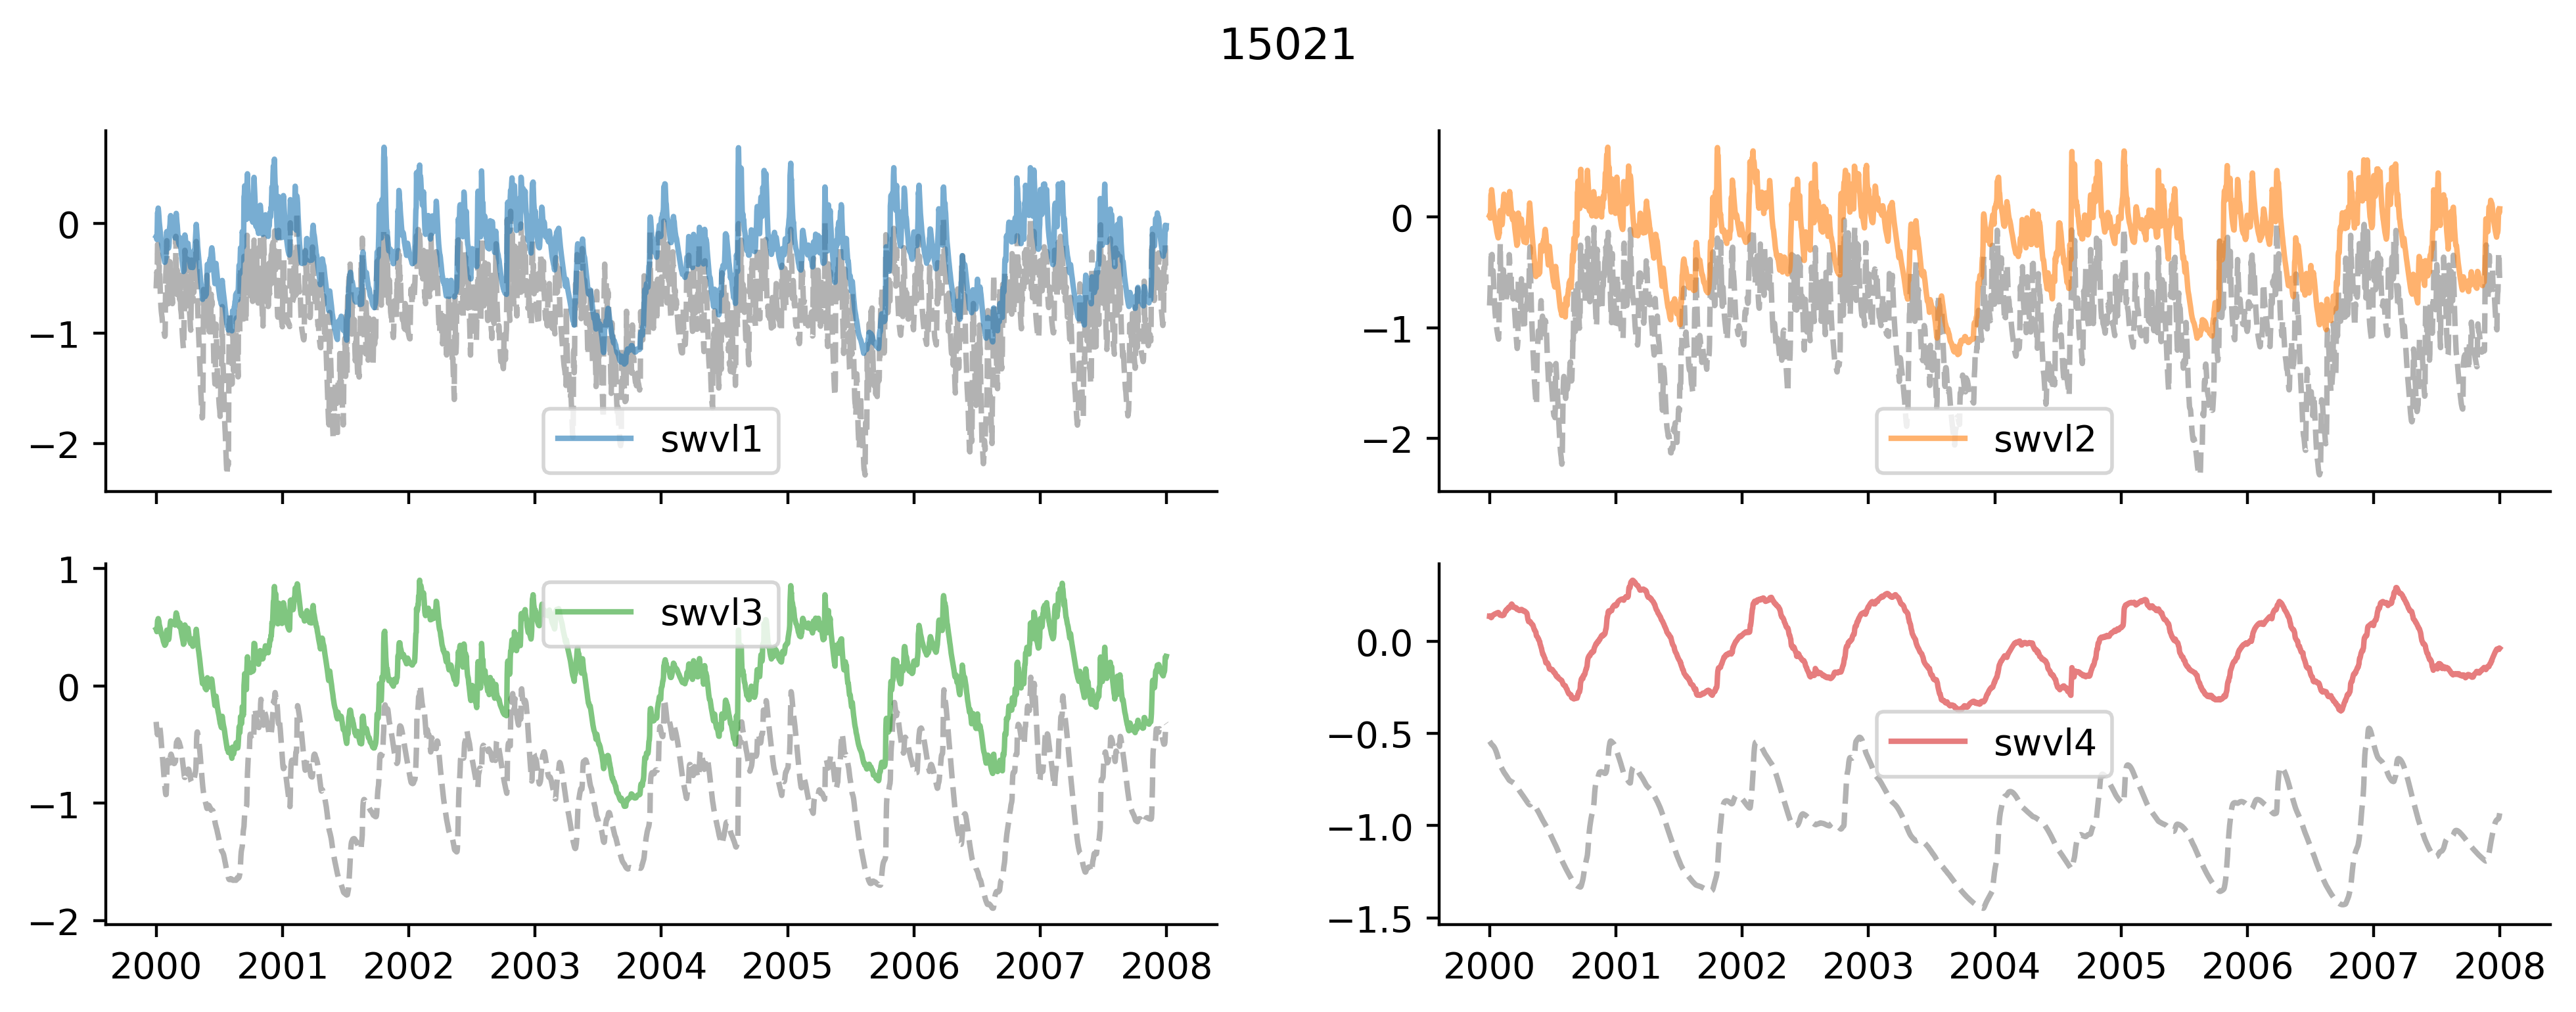

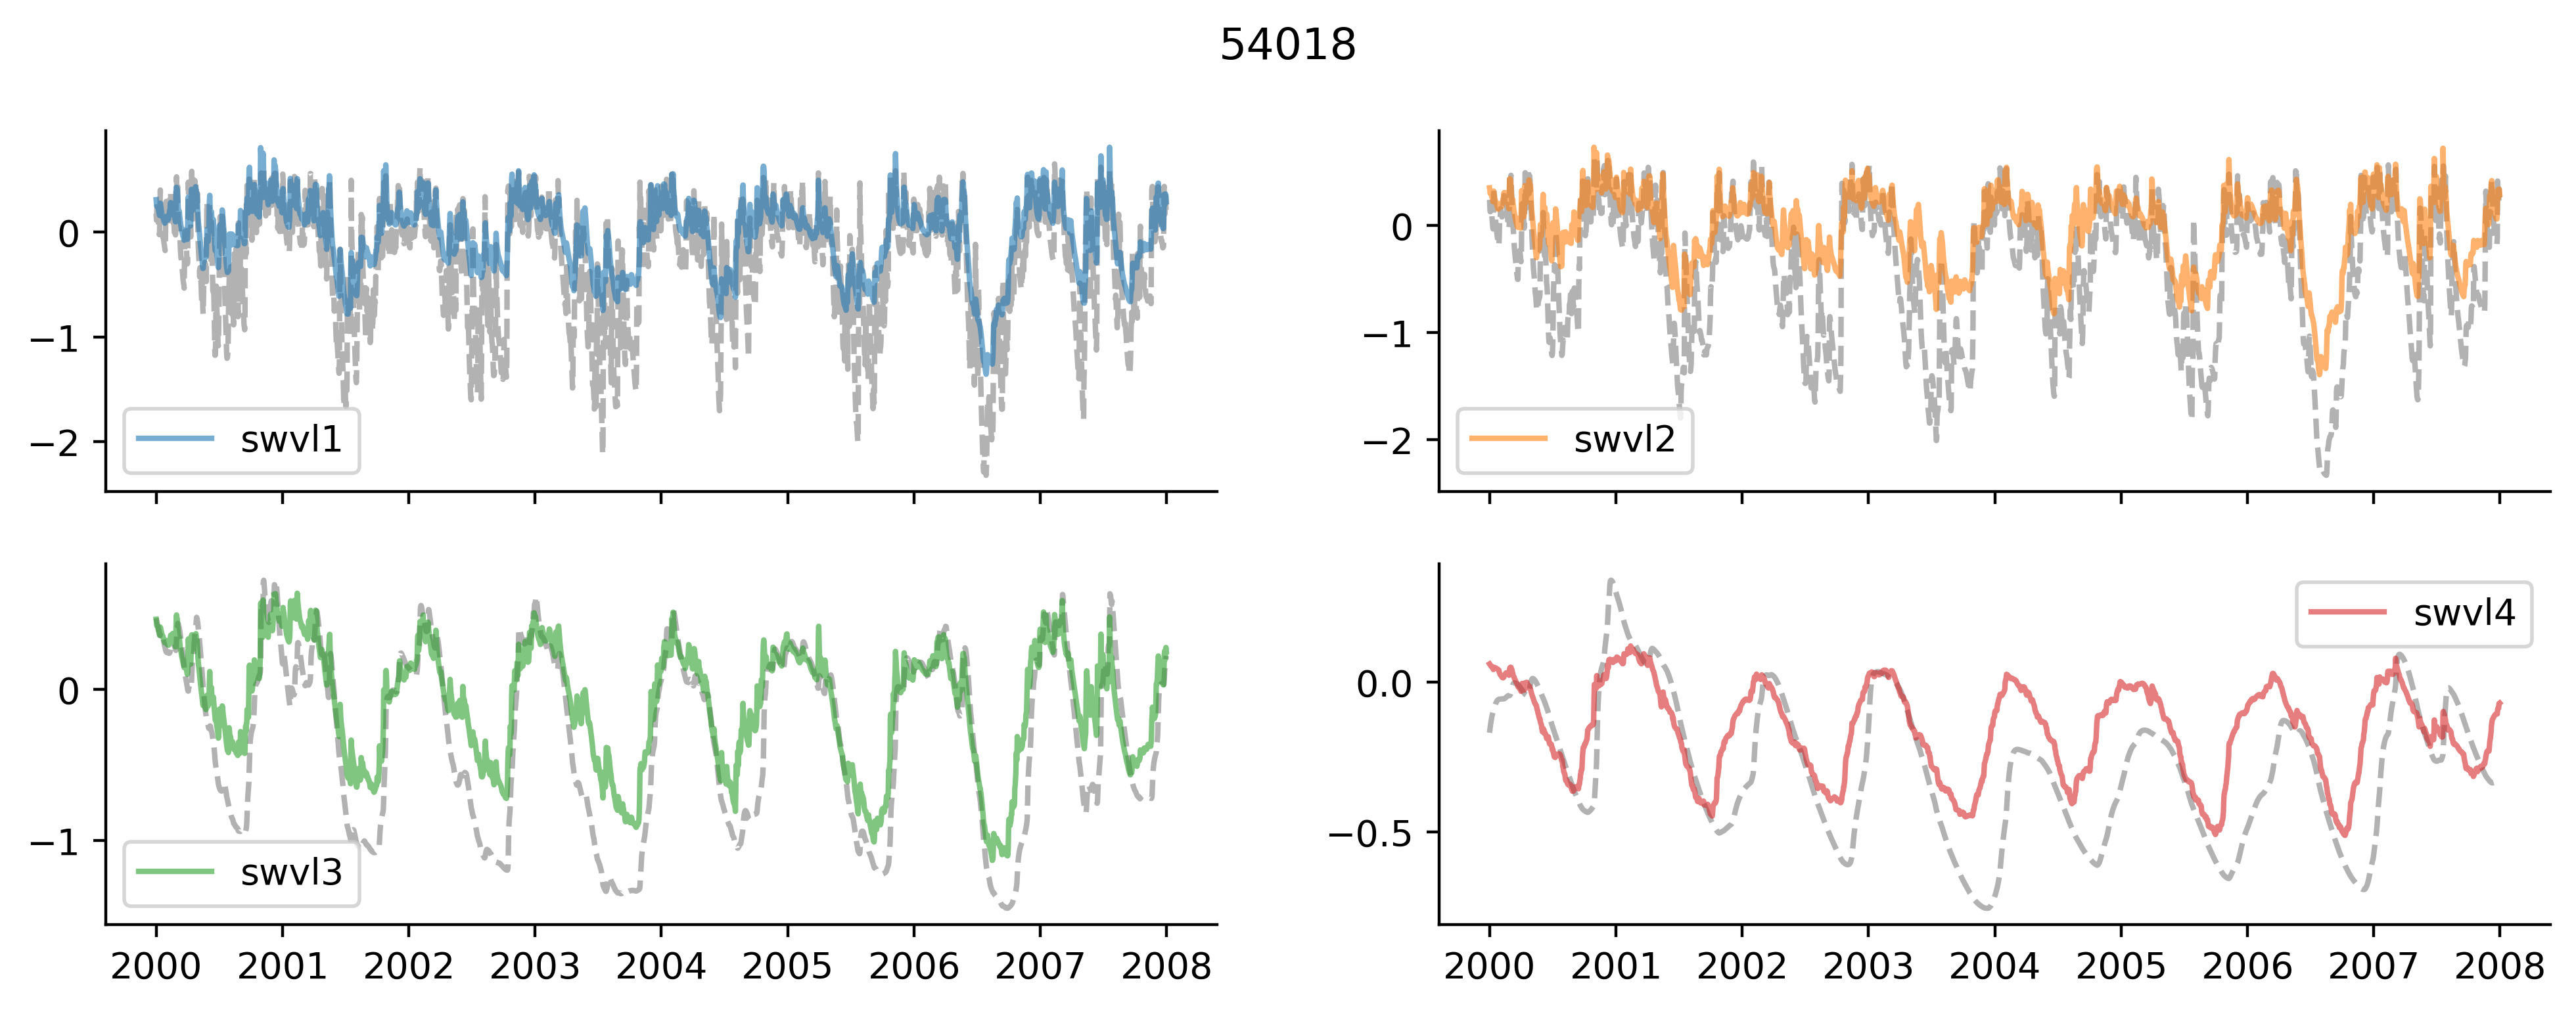

In [16]:
target_vars = list(all_models_preds.keys())
p = all_models_preds[target_vars[0]]["preds"]
time = slice("2000", "2007")

N = 3
pixels = np.random.choice(p.station_id.values, N, replace=False)
pixels = [27030, 38012, 39017]
pixels = [15021, 54018,]

with plt.rc_context({'figure.dpi': 400}):
    for px in pixels:
        if TARGET == "ESA":
            # f, axs = plt.subplots(1, 2, figsize=(12, 4 if TARGET != "ESA" else 2), sharex=True)
            f, axs = plt.subplots(figsize=(12, 4), sharex=True)
        else:
            f, axs = plt.subplots(2, 2, figsize=(12, 4 if TARGET != "ESA" else 2), sharex=True)
        f.suptitle(px)
        for ix, target_var in enumerate(target_vars):
            ax = axs[np.unravel_index(ix, (2, 2)) if TARGET != "ESA" else ix] if TARGET != "ESA" else axs
            preds = all_models_preds[target_var]["preds"]
            data = preds.sel(station_id=px, time=time)

            ax.plot(data.time, data.obs, color="k", ls="--", alpha=0.3)
            ax.plot(data.time, data.sim, color=f"C{ix}", ls="-", alpha=0.6, label=f"{target_var}")
            ax.legend()
            sns.despine()

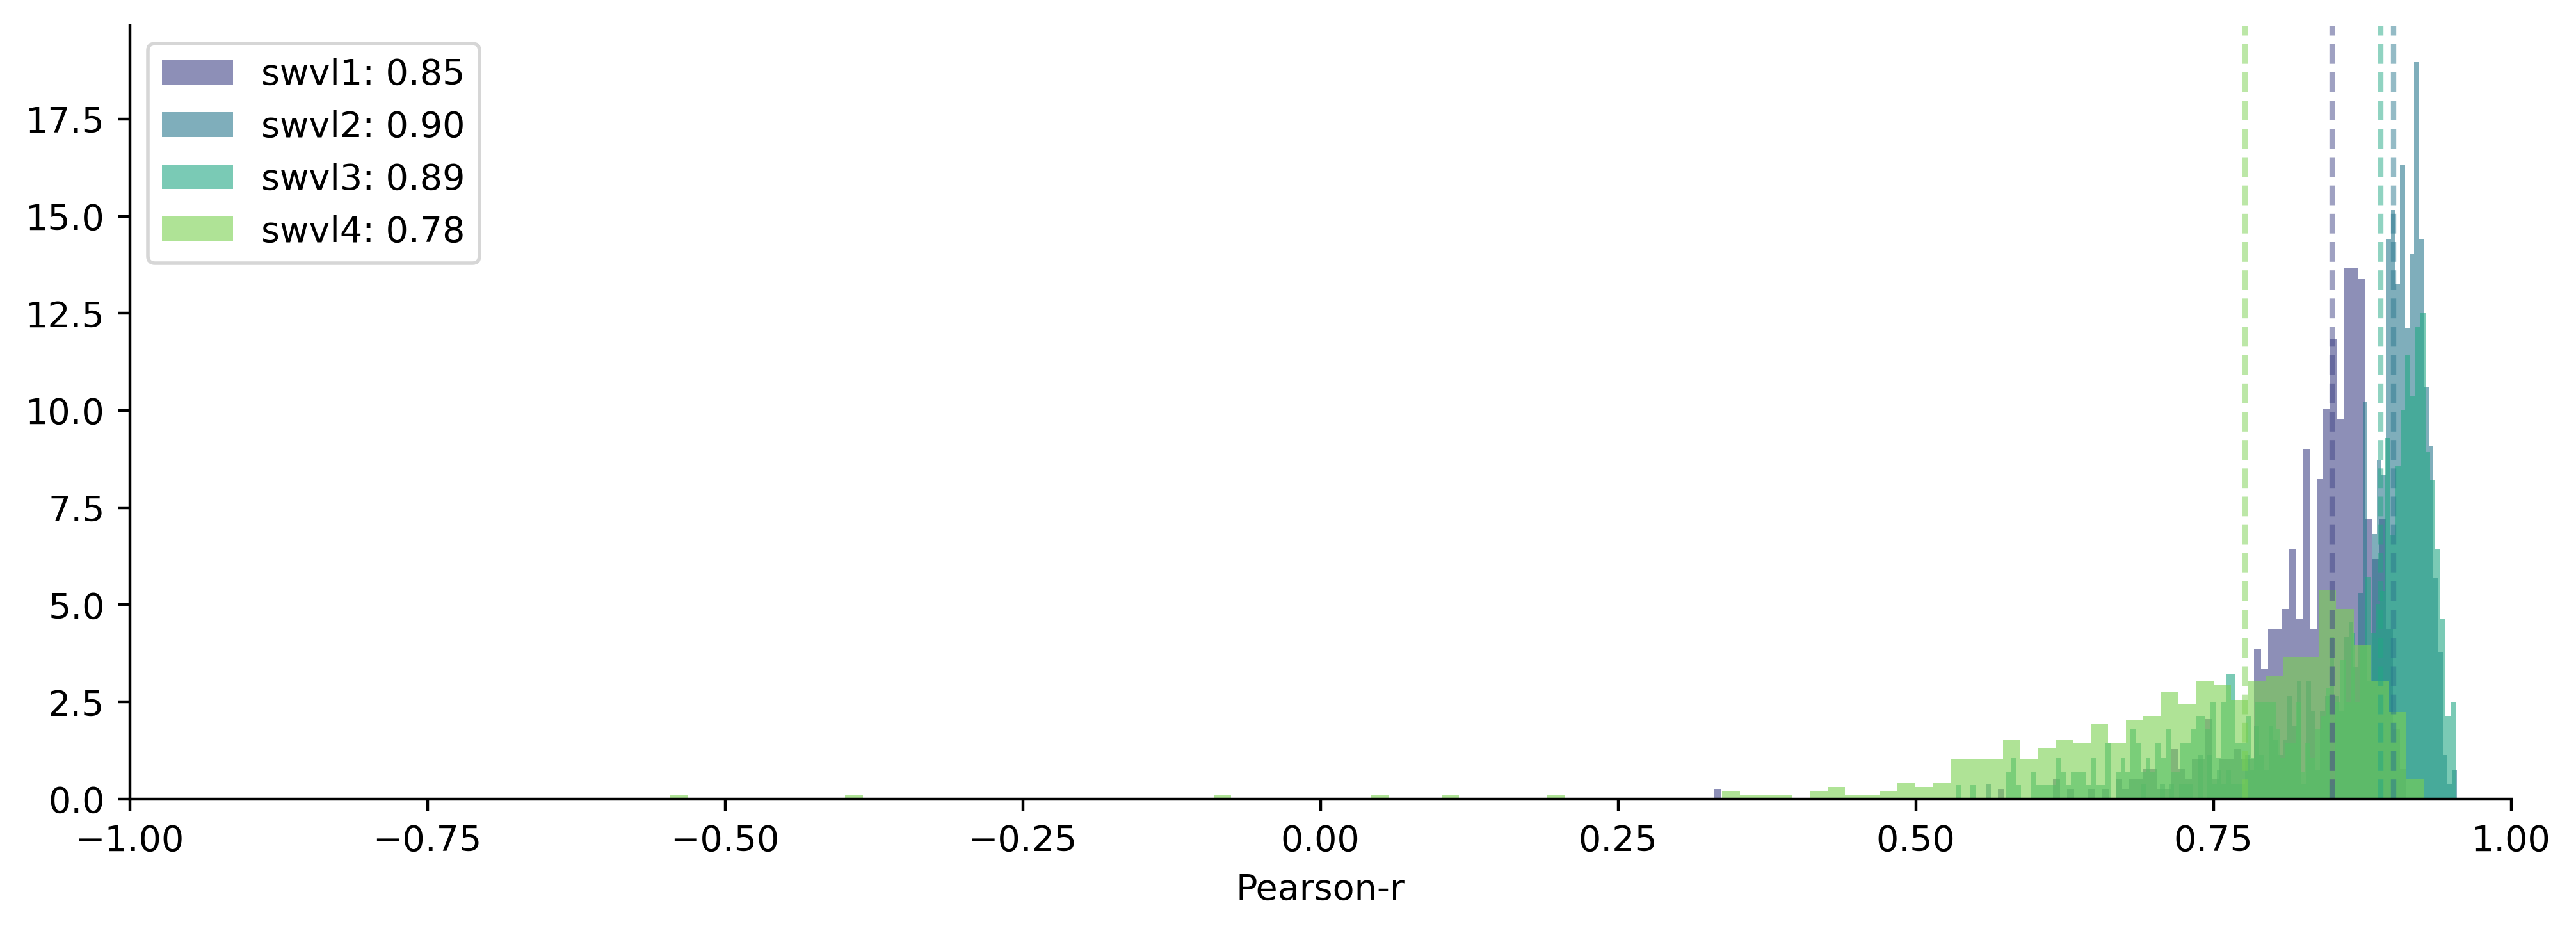

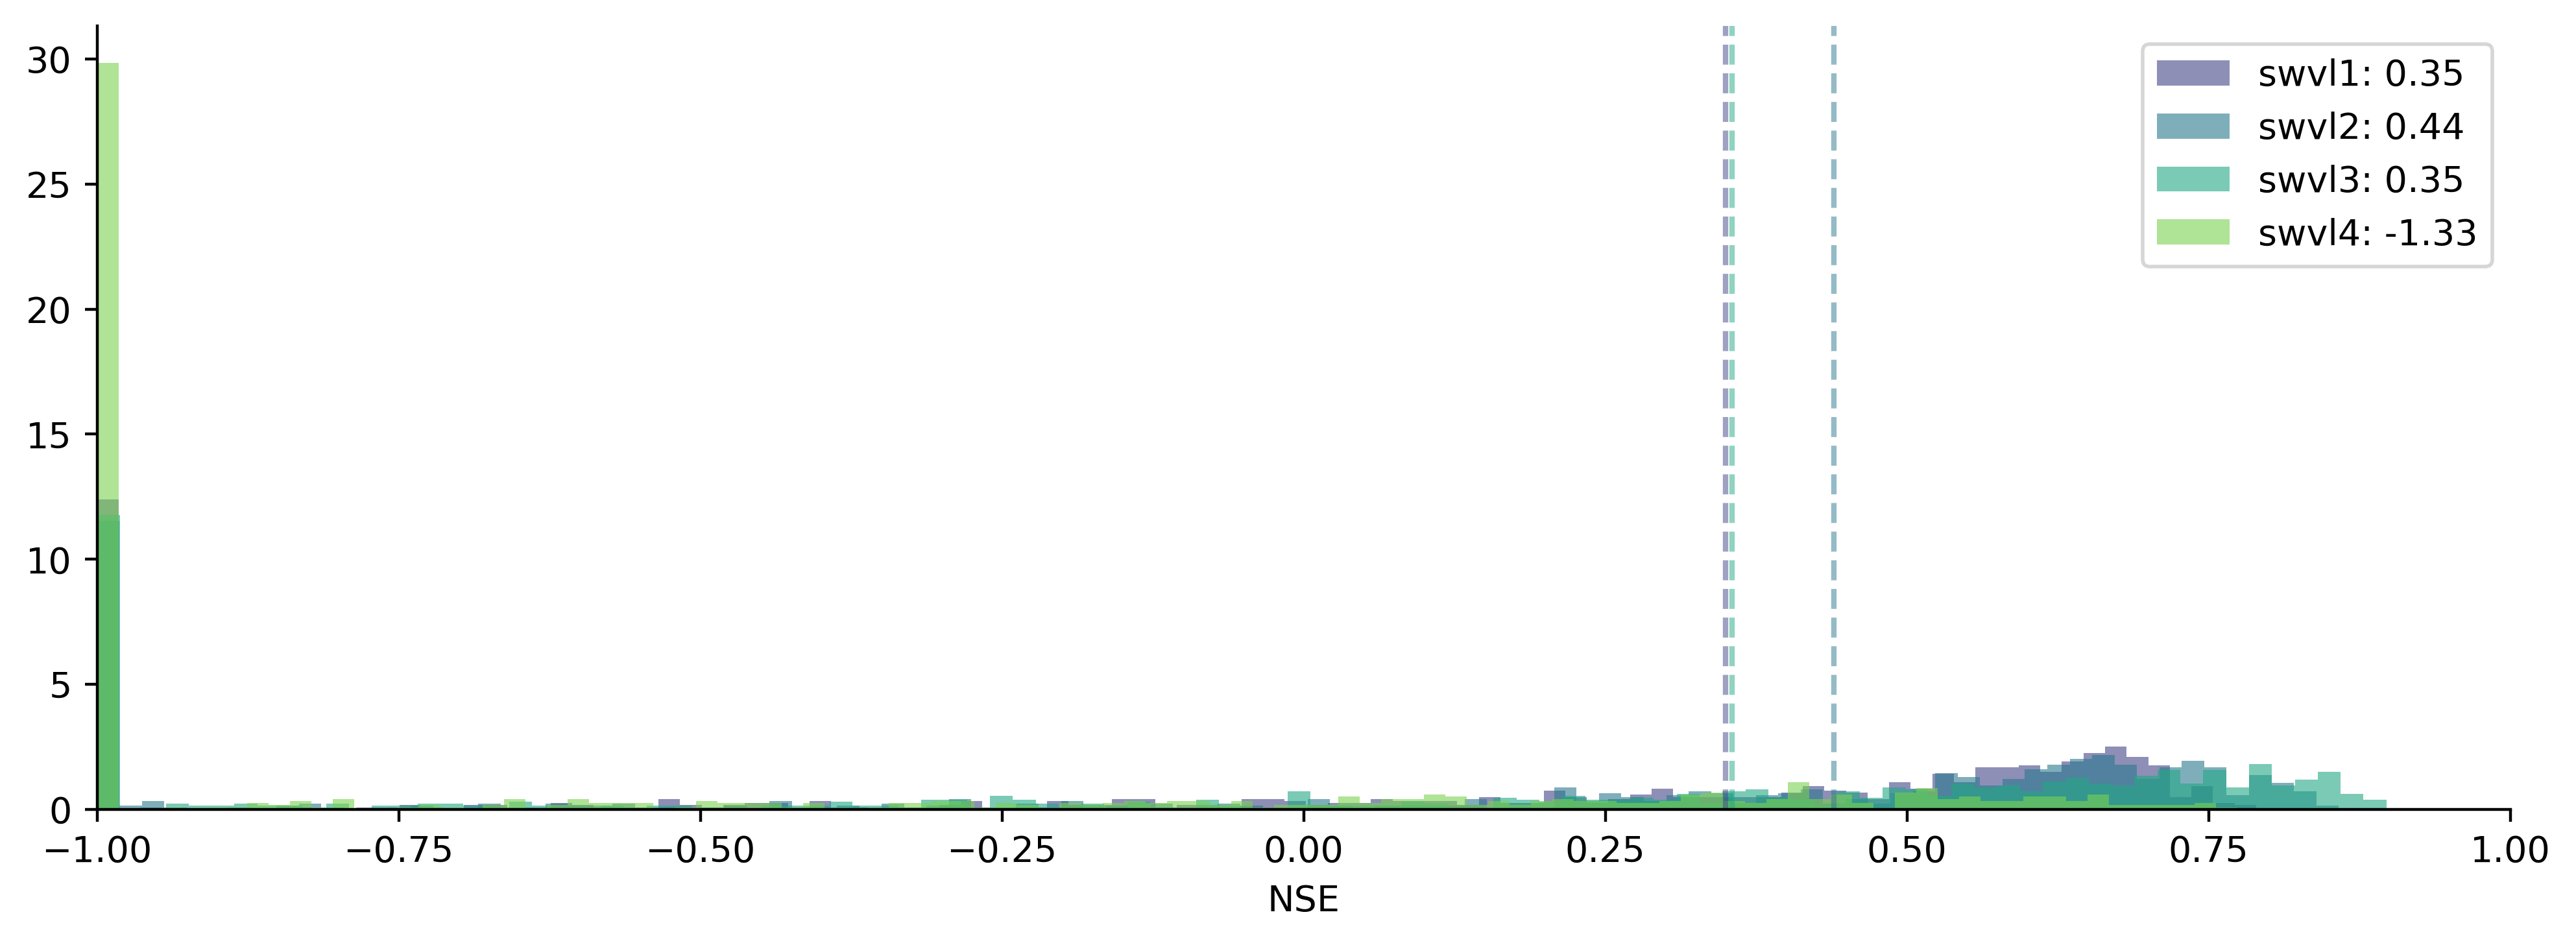

In [48]:
for metric in ["Pearson-r", "NSE"]:

    with plt.rc_context({'figure.dpi': 400}):
    #     metric = "Pearson-r"
        f, ax = plt.subplots(figsize=(12, 4))

        colors = sns.color_palette("viridis", n_colors=len(target_vars))
        for ix, target_var in enumerate(target_vars):
            errors = all_models_preds[target_var]["errors"]
            nse = errors[metric]

            ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"{target_var}: {nse.median().values:.2f}", alpha=0.6, color=colors[ix]);
            ax.axvline(nse.median(), color=colors[ix], ls="--", alpha=0.5)

        ax.set_xlabel(metric)
        ax.set_xlim(-1, 1)
        ax.legend()
        sns.despine()

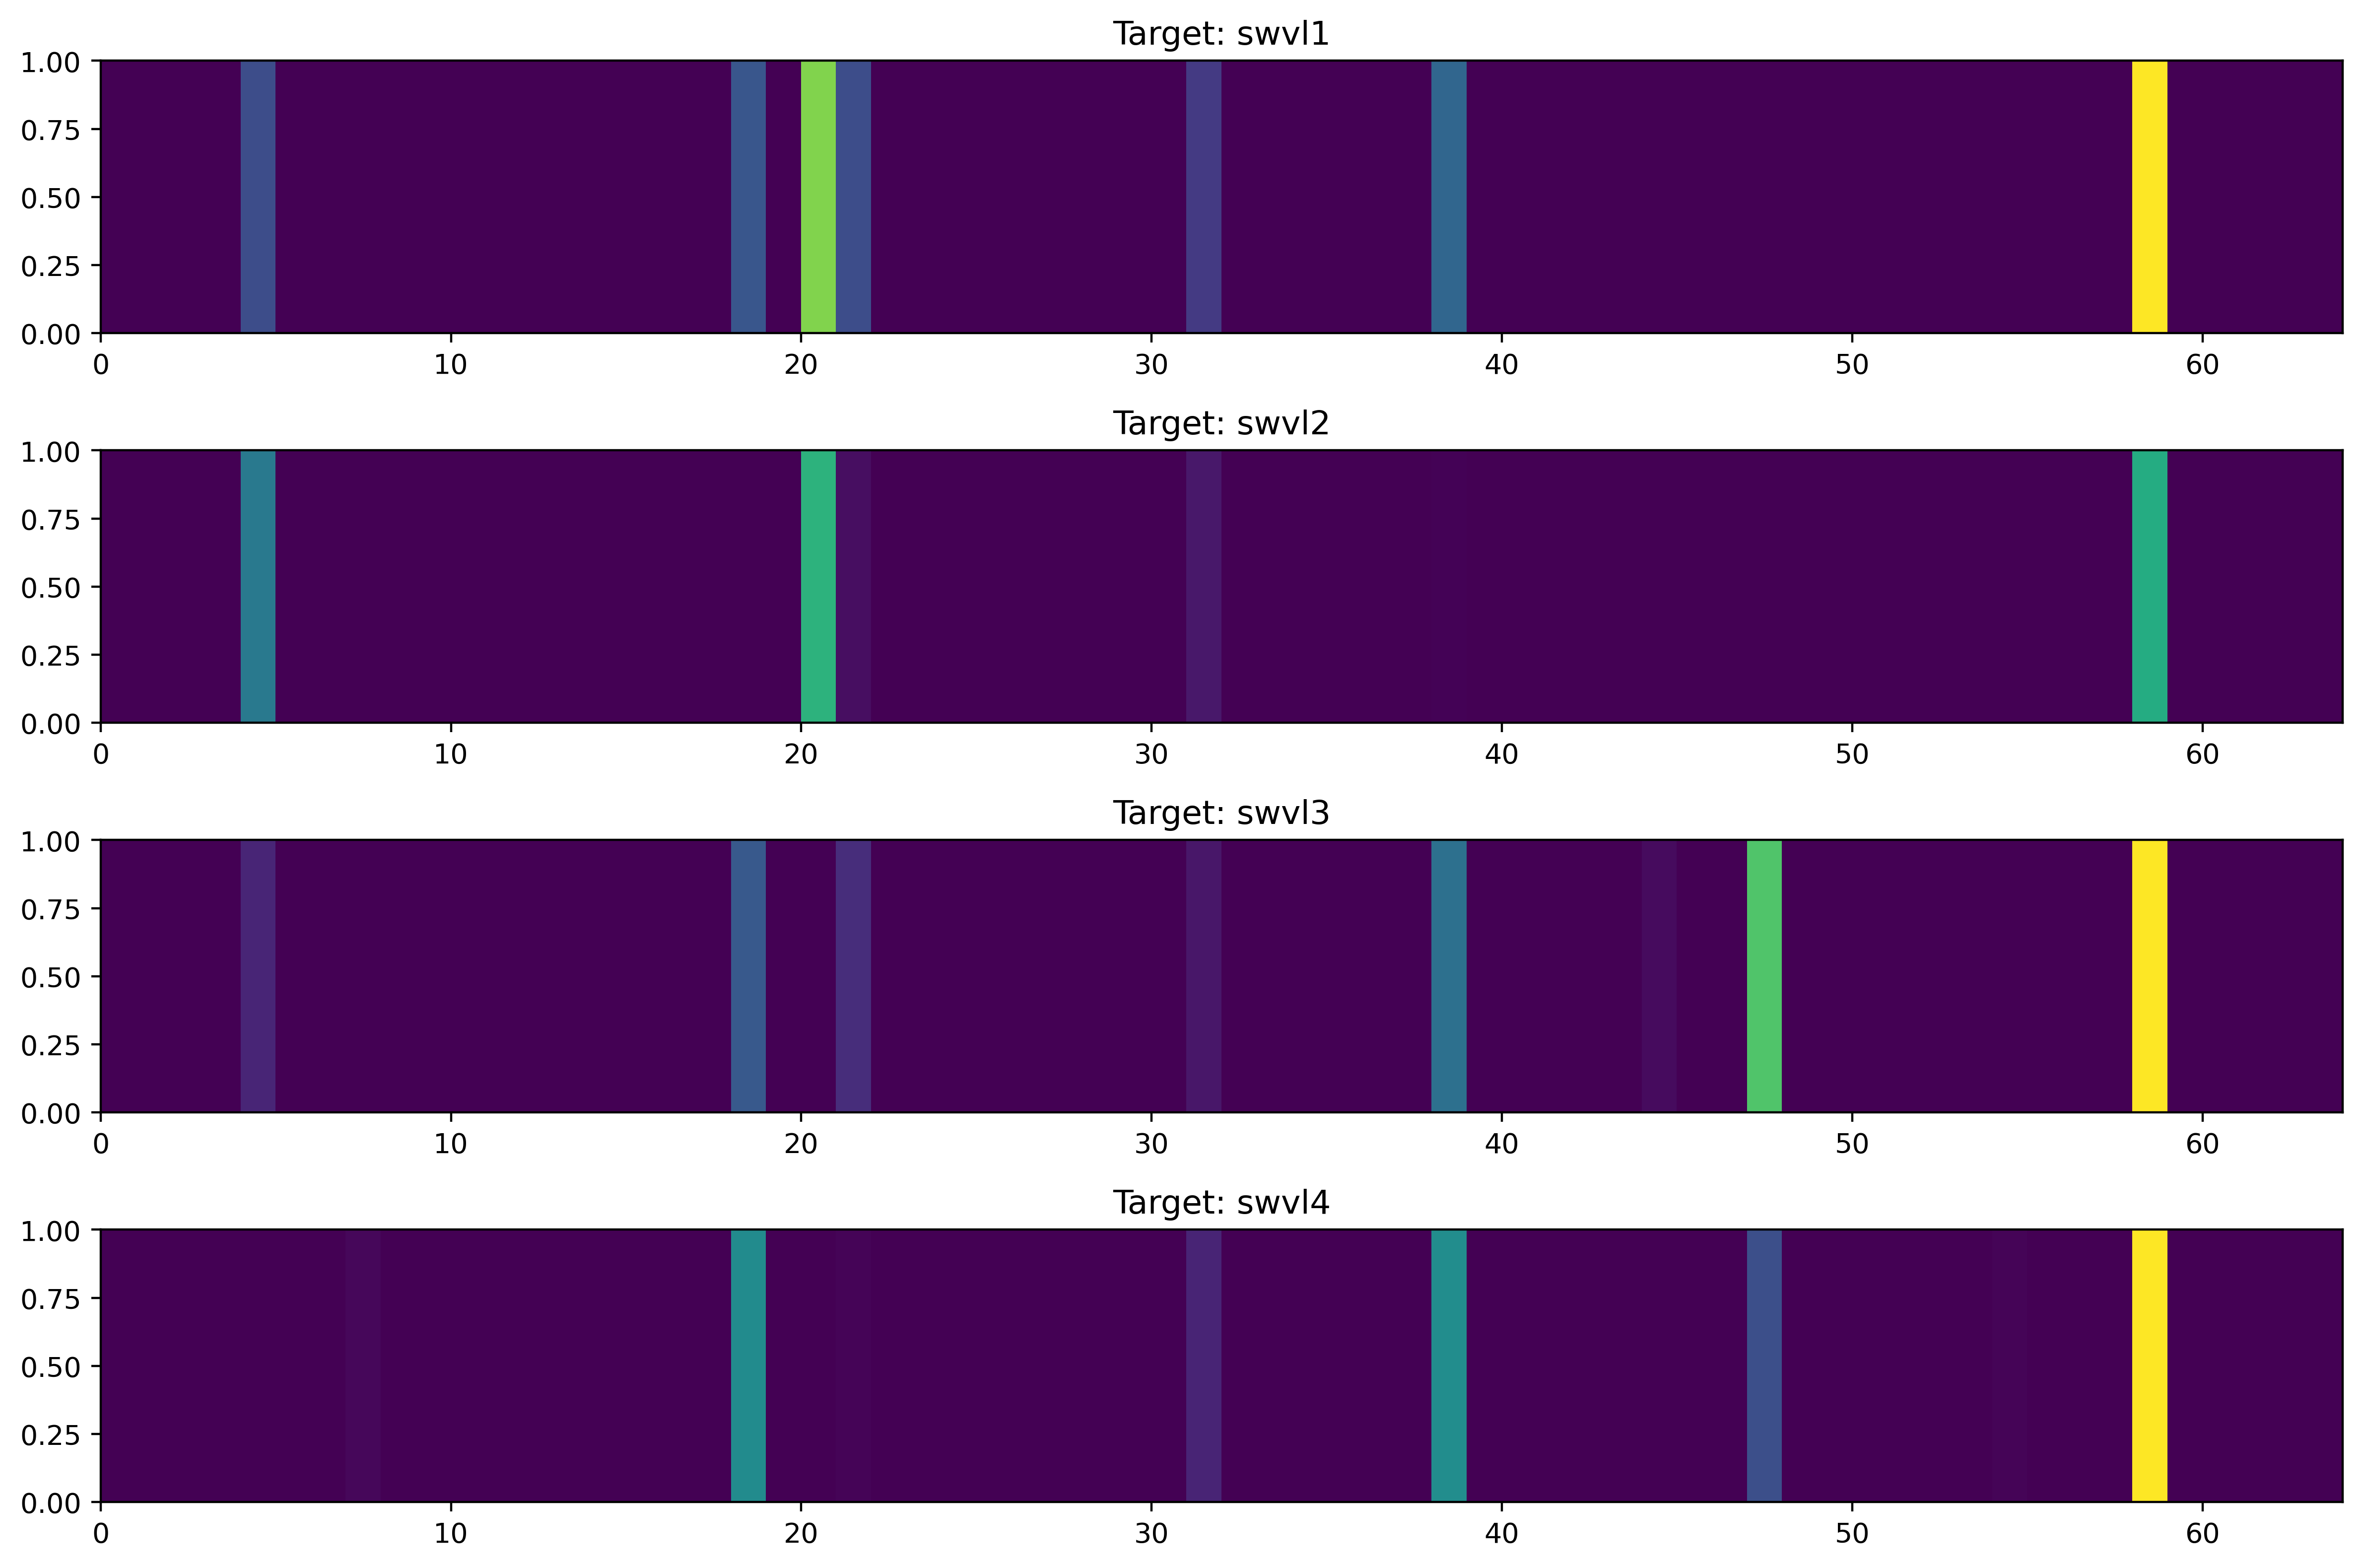

In [18]:
from scripts.cell_state.analysis import get_model_weights, plot_weights

if MODEL == "linear":
    with plt.rc_context({'figure.dpi': 400}):
        n_plots = len(target_vars)
        f, axs = plt.subplots(n_plots, 1, figsize=(12, 2*n_plots))

        for ix, target_var in enumerate(target_vars):
            model = all_models_preds[target_var]["model"]
            ax = axs[ix]
            w, b = get_model_weights(model)
            plot_weights(np.abs(w), kwargs={"vmin": 0.1, "vmax": 0.3}, ax=ax, cbar=False)
            ax.set_title(f"Target: {target_var}")
        plt.tight_layout()

# Spatial shuffling

In [19]:
# shuffle the station_ids 
# https://stackoverflow.com/a/35646937/9940782

from scripts.cell_state.timeseries_dataset import shuffle_basin_dim
from sklearn.utils import shuffle
from scripts.cell_state.timeseries_dataset import get_matching_dim

In [20]:
# join train/test_cs
train_times = train_cs.time.values
test_times = test_cs.time.values
cs = xr.concat([train_cs, test_cs], dim="time")

### Shuffle all of the station ids (shuffle in space)

In [21]:
np.random.seed(10)

copy_sm = target_ds.copy()
copy_sm["station_id"] = copy_sm["station_id"].astype(int)
copy_cs = cs.copy()
copy_cs["station_id"] = copy_cs["station_id"].astype(int)

# matching_stations
sm_sids, cs_sids = get_matching_dim(
    copy_sm, copy_cs, "station_id"
)
copy_sm = copy_sm.sel(station_id=sm_sids)
copy_cs = copy_cs.sel(station_id=cs_sids)

mapping = dict(zip(
    # original value: shuffled key
    copy_sm.station_id.values,
    shuffle(copy_sm.station_id.values),
))

inv_mapping = {
    # shuffled key: original value
    v: k for (k, v) in mapping.items()
}

In [22]:
shuffled_sm = copy_sm.copy()
shuffled_sm["station_id"] = [mapping[sid] for sid in shuffled_sm["station_id"].values]
assert shuffled_sm.station_id.values[0] == mapping[target_ds.station_id.values[0]]

shuffled_cs = copy_cs.copy()
shuffled_cs["station_id"] = [mapping[sid] for sid in shuffled_cs["station_id"].values]
assert shuffled_sm.station_id.values[0] == mapping[cs.station_id.values[0]]

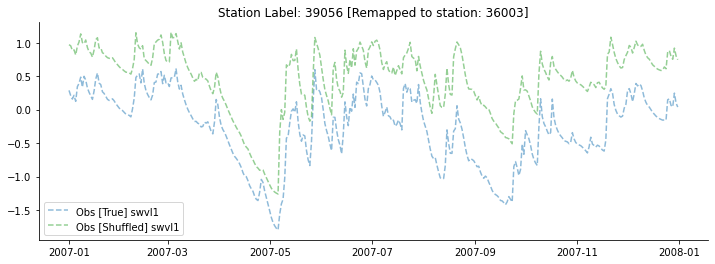

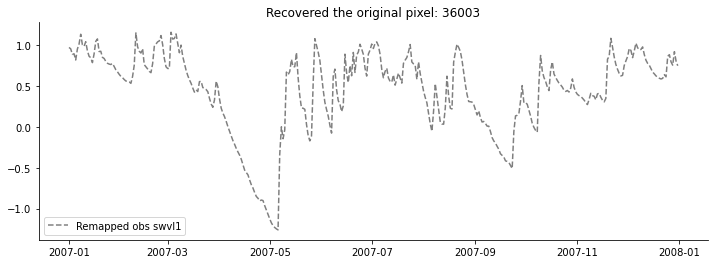

In [23]:
px = np.random.choice(shuffled_sm.station_id)

if TARGET == "ESA":
    plot_var = "7_day_smooth_sm"
elif TARGET == "ERA5":
    plot_var = "swvl1"
else: 
    assert False

data = target_ds.sel(time="2007", station_id=px)
shuff = shuffled_sm.sel(time="2007", station_id=px)
unshuffled_data = target_ds.sel(time="2007", station_id=inv_mapping[px])

# plot_var = "dim0"
# data = cs.sel(time="2007", station_id=px)
# shuff = shuffled_cs.sel(time="2007", station_id=px)
# unshuffled_data = cs.sel(time="2007", station_id=mapping[px])

f, ax = plt.subplots(figsize=(12, 4))

ax.plot(data.time, data[plot_var], color="C0", ls="--", alpha=0.5, label=f"Obs [True] {plot_var}")
ax.plot(data.time, shuff[plot_var], color="C2", ls="--", alpha=0.5, label=f"Obs [Shuffled] {plot_var}")

ax.legend()
ax.set_title(f"Station Label: {data.station_id.values} [Remapped to station: {inv_mapping[px]}]")
sns.despine()

f, ax = plt.subplots(figsize=(12, 4))

ax.plot(data.time, unshuffled_data[plot_var], color="k", ls="--", alpha=0.5, label=f"Remapped obs {plot_var}")
ax.set_title(f"Recovered the original pixel: {inv_mapping[px]}")

ax.legend()
sns.despine()

### Calculate shuffled datasets for each variable

In [24]:
# easier to just switch the arrays in numpy than recalculating the dataloaders etc.
# var_ = "swvl1"
# all_train_test[var_]["train"]
# all_train_test[var_]["test"]["station_ids"]

In [25]:
if not "shuffled_train_test" in list(globals().keys()):
# if True:
    shuffled_train_test = create_train_test_default_dict_for_all_target_vars(
        train_cs=shuffled_cs.sel(time=train_times),
        test_cs=shuffled_cs.sel(time=test_times),
        train_target_ds=train_target_ds,
        test_target_ds=test_target_ds,
        input_variables=shuffled_cs.data_vars
    )

** STARTING swvl1 **


Extracting Data: 100%|██████████| 16175/16175 [02:01<00:00, 133.13it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 10467/10467 [01:16<00:00, 136.43it/s]


Merging and reshaping arrays
** STARTING swvl2 **


Extracting Data: 100%|██████████| 16184/16184 [02:00<00:00, 134.71it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 10467/10467 [01:17<00:00, 135.32it/s]


Merging and reshaping arrays
** STARTING swvl3 **


Extracting Data: 100%|██████████| 16175/16175 [02:00<00:00, 134.22it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 10467/10467 [01:17<00:00, 135.59it/s]


Merging and reshaping arrays
** STARTING swvl4 **


Extracting Data: 100%|██████████| 16175/16175 [02:00<00:00, 134.62it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 10467/10467 [01:18<00:00, 133.13it/s]


Merging and reshaping arrays


In [26]:
if not "shuffled_model_preds" in globals().keys():
# if True:
    if MODEL == "linear":
        shuffled_model_preds = train_and_evaluate_models(shuffled_train_test, evaluate_set="test")
    elif MODEL == "nonlinear":
        shuffled_model_preds = train_and_evaluate_models(shuffled_train_test, evaluate_set="test", hidden_sizes=[20, 10])
    else:
        assert False

** swvl1 linear model **
-- Epoch 1
Norm: 0.54, NNZs: 38, Bias: -0.098672, T: 3726662, Avg. loss: 0.053046
Total training time: 2.85 seconds.
-- Epoch 2
Norm: 0.54, NNZs: 38, Bias: -0.102042, T: 7453324, Avg. loss: 0.053033
Total training time: 6.02 seconds.
-- Epoch 3
Norm: 0.54, NNZs: 38, Bias: -0.097601, T: 11179986, Avg. loss: 0.053030
Total training time: 9.16 seconds.
-- Epoch 4
Norm: 0.54, NNZs: 37, Bias: -0.096808, T: 14906648, Avg. loss: 0.053030
Total training time: 12.30 seconds.
-- Epoch 5
Norm: 0.54, NNZs: 38, Bias: -0.098768, T: 18633310, Avg. loss: 0.053028
Total training time: 15.45 seconds.
-- Epoch 6
Norm: 0.54, NNZs: 39, Bias: -0.098915, T: 22359972, Avg. loss: 0.053028
Total training time: 18.61 seconds.
Convergence after 6 epochs took 18.90 seconds


Calculating Errors: 100%|██████████| 667/667 [00:15<00:00, 43.99it/s, 106001]




** swvl2 linear model **
-- Epoch 1
Norm: 0.31, NNZs: 15, Bias: 0.269991, T: 3728766, Avg. loss: 0.050419
Total training time: 3.33 seconds.
-- Epoch 2
Norm: 0.31, NNZs: 16, Bias: 0.265681, T: 7457532, Avg. loss: 0.050413
Total training time: 6.96 seconds.
-- Epoch 3
Norm: 0.31, NNZs: 18, Bias: 0.265248, T: 11186298, Avg. loss: 0.050413
Total training time: 10.56 seconds.
-- Epoch 4
Norm: 0.31, NNZs: 17, Bias: 0.264629, T: 14915064, Avg. loss: 0.050412
Total training time: 14.19 seconds.
-- Epoch 5
Norm: 0.30, NNZs: 17, Bias: 0.269425, T: 18643830, Avg. loss: 0.050410
Total training time: 17.84 seconds.
-- Epoch 6
Norm: 0.31, NNZs: 16, Bias: 0.267697, T: 22372596, Avg. loss: 0.050412
Total training time: 21.47 seconds.
Convergence after 6 epochs took 21.77 seconds


Calculating Errors: 100%|██████████| 667/667 [00:15<00:00, 44.26it/s, 106001]




** swvl3 linear model **
-- Epoch 1
Norm: 0.56, NNZs: 39, Bias: -0.127569, T: 3726662, Avg. loss: 0.051623
Total training time: 2.83 seconds.
-- Epoch 2
Norm: 0.56, NNZs: 41, Bias: -0.126239, T: 7453324, Avg. loss: 0.051608
Total training time: 5.93 seconds.
-- Epoch 3
Norm: 0.55, NNZs: 39, Bias: -0.125259, T: 11179986, Avg. loss: 0.051604
Total training time: 9.04 seconds.
-- Epoch 4
Norm: 0.56, NNZs: 38, Bias: -0.126938, T: 14906648, Avg. loss: 0.051605
Total training time: 12.14 seconds.
-- Epoch 5
Norm: 0.55, NNZs: 40, Bias: -0.125915, T: 18633310, Avg. loss: 0.051603
Total training time: 15.23 seconds.
-- Epoch 6
Norm: 0.56, NNZs: 41, Bias: -0.131034, T: 22359972, Avg. loss: 0.051602
Total training time: 18.32 seconds.
Convergence after 6 epochs took 18.63 seconds


Calculating Errors: 100%|██████████| 667/667 [00:15<00:00, 44.05it/s, 106001]




** swvl4 linear model **
-- Epoch 1
Norm: 0.42, NNZs: 32, Bias: -0.129815, T: 3726662, Avg. loss: 0.051864
Total training time: 3.10 seconds.
-- Epoch 2
Norm: 0.42, NNZs: 32, Bias: -0.132878, T: 7453324, Avg. loss: 0.051852
Total training time: 6.46 seconds.
-- Epoch 3
Norm: 0.42, NNZs: 32, Bias: -0.130840, T: 11179986, Avg. loss: 0.051847
Total training time: 9.86 seconds.
-- Epoch 4
Norm: 0.42, NNZs: 31, Bias: -0.131439, T: 14906648, Avg. loss: 0.051848
Total training time: 13.23 seconds.
-- Epoch 5
Norm: 0.42, NNZs: 31, Bias: -0.132704, T: 18633310, Avg. loss: 0.051847
Total training time: 16.61 seconds.
-- Epoch 6
Norm: 0.41, NNZs: 32, Bias: -0.129496, T: 22359972, Avg. loss: 0.051846
Total training time: 19.96 seconds.
Convergence after 6 epochs took 20.27 seconds


Calculating Errors: 100%|██████████| 667/667 [00:14<00:00, 44.63it/s, 106001]


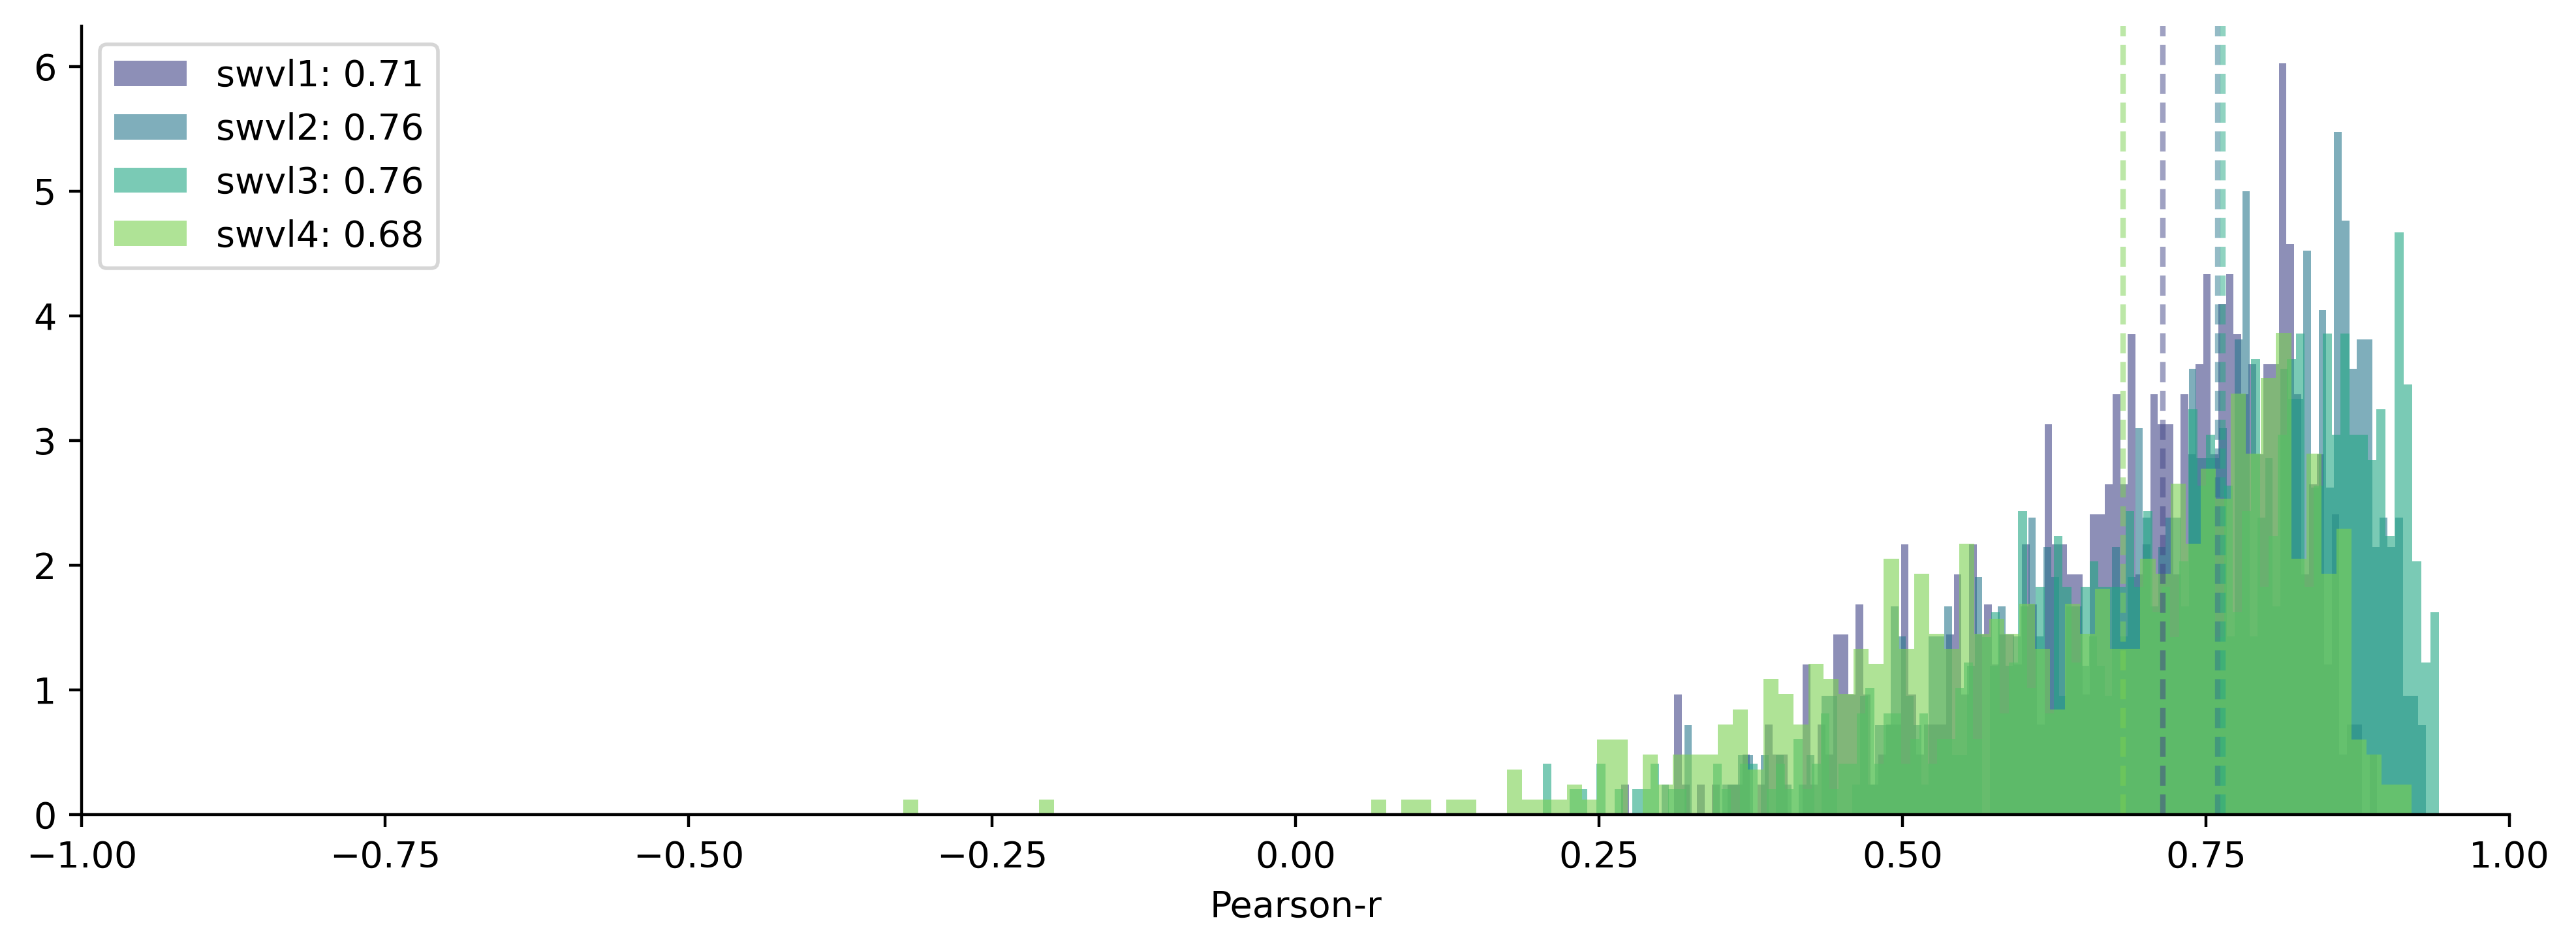

In [47]:
metric = "Pearson-r"
with plt.rc_context({"figure.dpi": 400}):
    f, ax = plt.subplots(figsize=(12, 4))

    colors = sns.color_palette("viridis", n_colors=len(target_vars))
    for ix, target_var in enumerate(shuffled_model_preds.keys()):
        errors = shuffled_model_preds[target_var]["errors"]
        nse = errors[metric]

        ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"{target_var}: {nse.median().values:.2f}", alpha=0.6, color=colors[ix]);
        ax.axvline(nse.median(), color=colors[ix], ls="--", alpha=0.5)

    ax.set_xlabel(metric)
    ax.set_xlim(-1, 1)
    ax.legend()
    sns.despine()

### calculate distance between shuffled basins

In [28]:
# from scripts.cell_state.analysis import (save_probe_components, load_probe_components)

# original_model_errors = load_probe_components(run_dir)
# original_model_errors.keys()

In [29]:
_from = [sid for sid in mapping.keys()]
_to = [sid for sid in mapping.values()]

# calculate distance between (change CRS!)
# https://gis.stackexchange.com/a/279111/123489
# 3035 = crs for northern europe
distances = points.to_crs(epsg=3035).loc[_from].reset_index().distance(points.to_crs(epsg=3035).loc[_to].reset_index())
distances.index = points[_from].index
distances.name = "distance"
# in km
distances = distances / 1000

In [30]:
var_ = "swvl1" if TARGET == "ERA5" else "7_day_smooth_sm"
var_

'swvl1'

In [31]:
from typing import DefaultDict, Dict, List
from tqdm import tqdm
from collections import defaultdict


var_ = "swvl1" if TARGET == "ERA5" else "7_day_smooth_sm"
all_distance_nse_dataframes = {}
target_vars = [f"swvl{i+1}" for i in range(4)] if TARGET == "ERA5" else ["7_day_smooth_sm"]
for var_ in tqdm(target_vars, desc="Making Distance-NSE DataFrames"):
    errors = all_models_preds[var_]["errors"]
    shuff_errors = shuffled_model_preds[var_]["errors"]


    shuffled_basin_nses = defaultdict(list)
    for sid in mapping.keys():
        try:
            nse = errors["NSE"].to_dataframe().loc[sid].values[0]
            r2 = errors["Pearson-r"].to_dataframe().loc[sid].values[0]
            remapping_sid = inv_mapping[sid]
            shuffled_nse = shuff_errors["NSE"].to_dataframe().loc[sid].values[0]
            shuffled_r2 = shuff_errors["Pearson-r"].to_dataframe().loc[sid].values[0]

            shuffled_basin_nses["original_nse"].append(nse)
            shuffled_basin_nses["shuffled_nse"].append(shuffled_nse)
            shuffled_basin_nses["original_r2"].append(r2)
            shuffled_basin_nses["shuffled_r2"].append(shuffled_r2)

        except KeyError:
            shuffled_basin_nses["original_nse"].append(np.nan)
            shuffled_basin_nses["shuffled_nse"].append(np.nan)
            shuffled_basin_nses["original_r2"].append(np.nan)
            shuffled_basin_nses["shuffled_r2"].append(np.nan)

            
        shuffled_basin_nses["sid"].append(sid)

    shuffled_basin_nses = pd.DataFrame(shuffled_basin_nses).set_index("sid")
    shuffled_basin_nses["delta_nse"] = shuffled_basin_nses["original_nse"] - shuffled_basin_nses["shuffled_nse"]
    shuffled_basin_nses["delta_r2"] = shuffled_basin_nses["original_r2"] - shuffled_basin_nses["shuffled_r2"]
    dist_df = shuffled_basin_nses.join(distances)
    
    all_distance_nse_dataframes[var_] = dist_df
    
all_distance_nse_dataframes[var_].head()

Making Distance-NSE DataFrames: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it]


,original_nse,shuffled_nse,original_r2,shuffled_r2,delta_nse,delta_r2,distance
sid,,,,,,,
10002,-9.743356,-8.553891,0.852485,0.824627,-1.189465,0.027858,524.801786
10003,0.546485,-3.997756,0.839004,0.819307,4.544242,0.019698,697.055061
1001,0.274699,-24.804449,0.849216,0.756984,25.079148,0.092232,440.031631
101002,-10.253873,-29.433890,0.836011,0.636098,19.180017,0.199913,671.250860
101005,NaN,NaN,NaN,NaN,NaN,NaN,537.583052


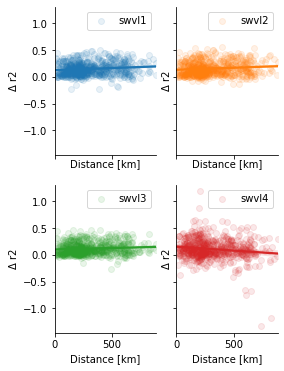

In [32]:
f, axs = plt.subplots(2, 2, figsize=(4, 6), sharex=True, sharey=True)
metric = "r2"
variables = [f"swvl{i+1}" for i in range(4)] if TARGET == "ERA5" else ["7_day_smooth_sm"]

for ix, var_ in enumerate(variables):
    ax = axs[np.unravel_index(ix, (2, 2))]
    dist_df = all_distance_nse_dataframes[var_]
    dist_df = dist_df.loc[abs(dist_df[f'delta_{metric}']) < 5]

    sns.regplot(x='distance', y=f'delta_{metric}', data=dist_df, fit_reg=True, ax=ax, scatter_kws={"alpha": 0.1}, line_kws=None, color=f"C{ix}", label=var_)
    ax.set_xlabel("Distance [km]")
    ax.set_ylabel(f"$\Delta$ {metric}")
    sns.despine()
    ax.legend()

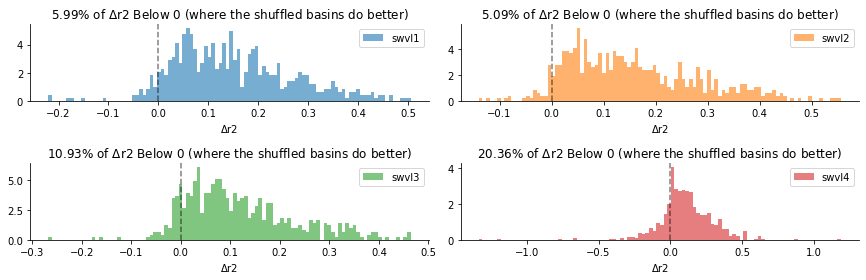

In [33]:
var_ = "swvl1"
metric = "r2"
variables = [f"swvl{i+1}" for i in range(4)] if TARGET == "ERA5" else ["7_day_smooth_sm"]

f, axs = plt.subplots(2, 2, figsize=(12, 4))

for ix, var_ in enumerate(variables):
    ax = axs[np.unravel_index(ix, (2, 2))]
    dist_df = all_distance_nse_dataframes[var_]
    ax.axvline(0, color="k", alpha=0.5, ls="--")
    ax.hist(dist_df[f'delta_{metric}'], alpha=0.6, bins=100, density=True, label=var_, color=f"C{ix}")
    prop_below_zero = float((dist_df < 0)[f'delta_{metric}'].mean())
    ax.set_title(f"{prop_below_zero * 100:.2f}% of $\Delta${metric} Below 0 (where the shuffled basins do better)")
    ax.set_xlabel(f"$\Delta${metric}")
    ax.legend()
    sns.despine()
plt.tight_layout()

# In Time

In [34]:
# assert False, "Are you running both experiments now?"

In [35]:
if TARGET == "ESA":
    time_sm = esa_ds.copy()

elif TARGET == "ERA5":
    time_sm = era5_ds.copy()

else: 
    assert False

time_cs = cs.copy()

In [36]:
# 180 day shift
shift_cs = time_cs.shift(time=180)
shift_sm = time_sm.shift(time=180)

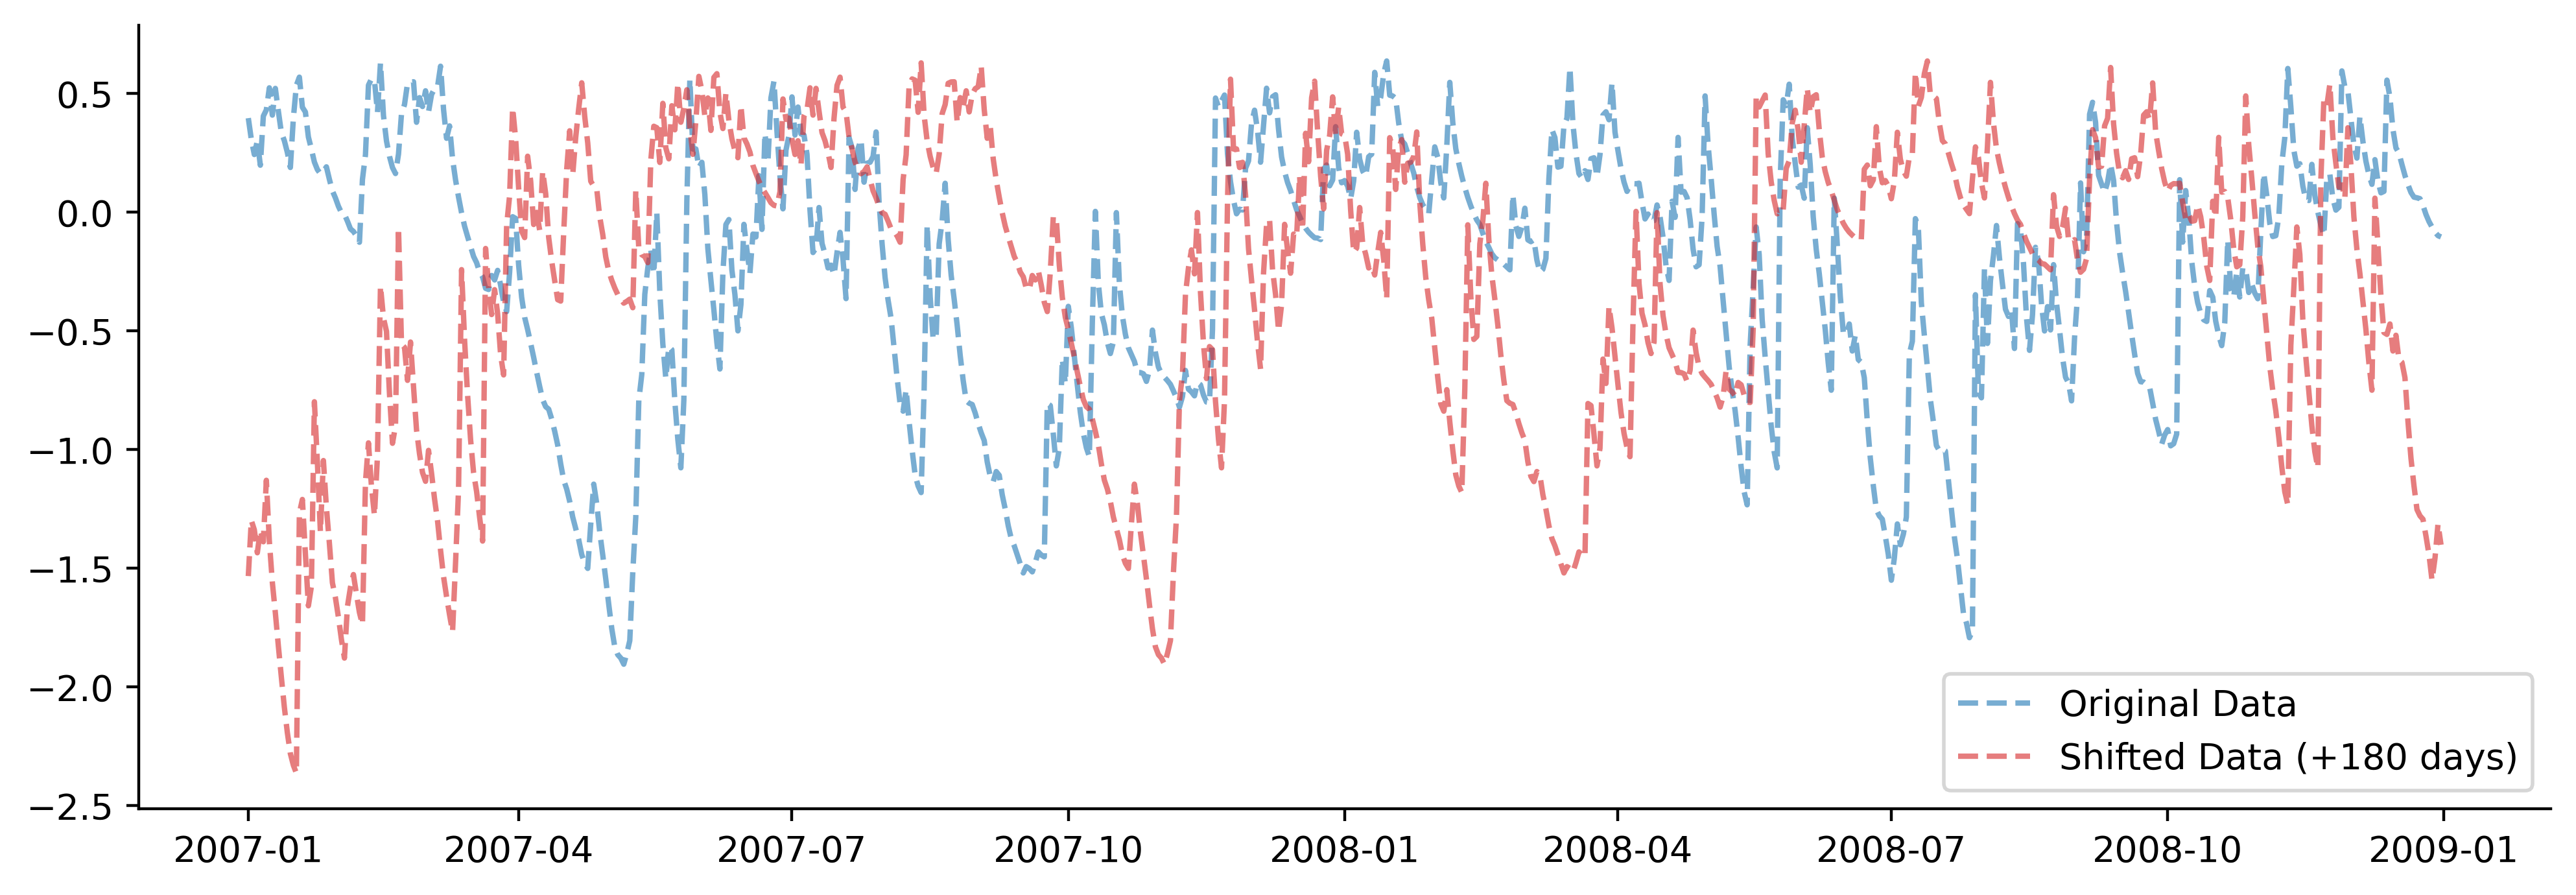

In [49]:
var_ = "swvl1"
with plt.rc_context({'figure.dpi': 400}):

    time = slice("2007", "2008")
    px = np.random.choice(shift_sm.station_id.values)

    if TARGET == "ESA":
        data = esa_ds.sel(station_id=px, time=time)[var_]
    elif TARGET == "ERA5":
        data = era5_ds.sel(station_id=px, time=time)[var_]
    else: 
        assert False

    shift = shift_sm.sel(station_id=px, time=time)[var_]

    f, ax = plt.subplots(figsize=(12, 4))
    ax.plot(data.time, data.values, color="C0", ls="--", alpha=0.6, label="Original Data")
    ax.plot(data.time, shift.values, color="C3", ls="--", alpha=0.6, label="Shifted Data (+180 days)")

    ax.legend()
    sns.despine()

### Make shifted data train/test

In [38]:
if not "shifted_train_test" in list(globals().keys()):
# if True:
    shifted_train_test = create_train_test_default_dict_for_all_target_vars(
        train_cs=shift_cs.sel(time=train_times),
        test_cs=shift_cs.sel(time=test_times),
        train_target_ds=train_target_ds,
        test_target_ds=test_target_ds,
        input_variables=shuffled_cs.data_vars
    )

** STARTING swvl1 **


Extracting Data: 100%|██████████| 15946/15946 [01:55<00:00, 137.70it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 10467/10467 [01:16<00:00, 137.07it/s]


Merging and reshaping arrays
** STARTING swvl2 **


Extracting Data: 100%|██████████| 15955/15955 [01:57<00:00, 135.86it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 10467/10467 [01:17<00:00, 134.31it/s]


Merging and reshaping arrays
** STARTING swvl3 **


Extracting Data: 100%|██████████| 10467/10467 [01:17<00:00, 134.70it/s]


Merging and reshaping arrays
** STARTING swvl4 **


Extracting Data: 100%|██████████| 15946/15946 [01:58<00:00, 135.10it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 10467/10467 [01:17<00:00, 135.15it/s]


Merging and reshaping arrays


In [39]:
if not "shifted_model_preds" in globals().keys():
# if True:
    if MODEL == "linear":
        shifted_model_preds = train_and_evaluate_models(shifted_train_test, evaluate_set="test")
    elif MODEL == "nonlinear":
        shifted_model_preds = train_and_evaluate_models(shifted_train_test, evaluate_set="test", hidden_sizes=[20, 10])
    else:
        assert False

** swvl1 linear model **
-- Epoch 1
Norm: 0.77, NNZs: 39, Bias: 0.029138, T: 3673836, Avg. loss: 0.047844
Total training time: 2.70 seconds.
-- Epoch 2
Norm: 0.77, NNZs: 38, Bias: 0.032897, T: 7347672, Avg. loss: 0.047806
Total training time: 5.69 seconds.
-- Epoch 3
Norm: 0.78, NNZs: 39, Bias: 0.032274, T: 11021508, Avg. loss: 0.047804
Total training time: 8.66 seconds.
-- Epoch 4
Norm: 0.77, NNZs: 39, Bias: 0.030304, T: 14695344, Avg. loss: 0.047803
Total training time: 11.61 seconds.
-- Epoch 5
Norm: 0.78, NNZs: 39, Bias: 0.031040, T: 18369180, Avg. loss: 0.047803
Total training time: 14.60 seconds.
-- Epoch 6
Norm: 0.77, NNZs: 39, Bias: 0.029460, T: 22043016, Avg. loss: 0.047801
Total training time: 17.57 seconds.
Convergence after 6 epochs took 17.85 seconds


Calculating Errors: 100%|██████████| 667/667 [00:15<00:00, 43.85it/s, 106001]




** swvl2 linear model **
-- Epoch 1
Norm: 0.36, NNZs: 24, Bias: 0.312741, T: 3675940, Avg. loss: 0.050219
Total training time: 3.15 seconds.
-- Epoch 2
Norm: 0.37, NNZs: 26, Bias: 0.298864, T: 7351880, Avg. loss: 0.050211
Total training time: 6.57 seconds.
-- Epoch 3
Norm: 0.36, NNZs: 25, Bias: 0.304891, T: 11027820, Avg. loss: 0.050208
Total training time: 10.04 seconds.
-- Epoch 4
Norm: 0.36, NNZs: 27, Bias: 0.302891, T: 14703760, Avg. loss: 0.050209
Total training time: 13.44 seconds.
-- Epoch 5
Norm: 0.36, NNZs: 27, Bias: 0.300213, T: 18379700, Avg. loss: 0.050208
Total training time: 16.83 seconds.
-- Epoch 6
Norm: 0.36, NNZs: 27, Bias: 0.302009, T: 22055640, Avg. loss: 0.050208
Total training time: 20.23 seconds.
Convergence after 6 epochs took 20.52 seconds


Calculating Errors: 100%|██████████| 667/667 [00:15<00:00, 44.36it/s, 106001]




** swvl3 linear model **
-- Epoch 1
Norm: 0.84, NNZs: 38, Bias: -0.018379, T: 3673836, Avg. loss: 0.044467
Total training time: 2.74 seconds.
-- Epoch 2
Norm: 0.83, NNZs: 39, Bias: -0.017720, T: 7347672, Avg. loss: 0.044424
Total training time: 5.78 seconds.
-- Epoch 3
Norm: 0.84, NNZs: 39, Bias: -0.014506, T: 11021508, Avg. loss: 0.044423
Total training time: 8.81 seconds.
-- Epoch 4
Norm: 0.83, NNZs: 39, Bias: -0.018075, T: 14695344, Avg. loss: 0.044420
Total training time: 11.85 seconds.
-- Epoch 5
Norm: 0.84, NNZs: 40, Bias: -0.017675, T: 18369180, Avg. loss: 0.044423
Total training time: 14.89 seconds.
-- Epoch 6
Norm: 0.83, NNZs: 38, Bias: -0.020412, T: 22043016, Avg. loss: 0.044421
Total training time: 17.91 seconds.
Convergence after 6 epochs took 18.20 seconds


Calculating Errors: 100%|██████████| 667/667 [00:15<00:00, 44.22it/s, 106001]




** swvl4 linear model **
-- Epoch 1
Norm: 0.84, NNZs: 44, Bias: -0.008161, T: 3673836, Avg. loss: 0.038990
Total training time: 2.62 seconds.
-- Epoch 2
Norm: 0.84, NNZs: 43, Bias: -0.011610, T: 7347672, Avg. loss: 0.038939
Total training time: 5.55 seconds.
-- Epoch 3
Norm: 0.84, NNZs: 44, Bias: -0.010234, T: 11021508, Avg. loss: 0.038938
Total training time: 8.51 seconds.
-- Epoch 4
Norm: 0.84, NNZs: 42, Bias: -0.011565, T: 14695344, Avg. loss: 0.038934
Total training time: 11.42 seconds.
-- Epoch 5
Norm: 0.84, NNZs: 44, Bias: -0.011953, T: 18369180, Avg. loss: 0.038936
Total training time: 14.37 seconds.
-- Epoch 6
Norm: 0.84, NNZs: 43, Bias: -0.012488, T: 22043016, Avg. loss: 0.038934
Total training time: 17.30 seconds.
Convergence after 6 epochs took 17.59 seconds


Calculating Errors: 100%|██████████| 667/667 [00:15<00:00, 42.99it/s, 106001]


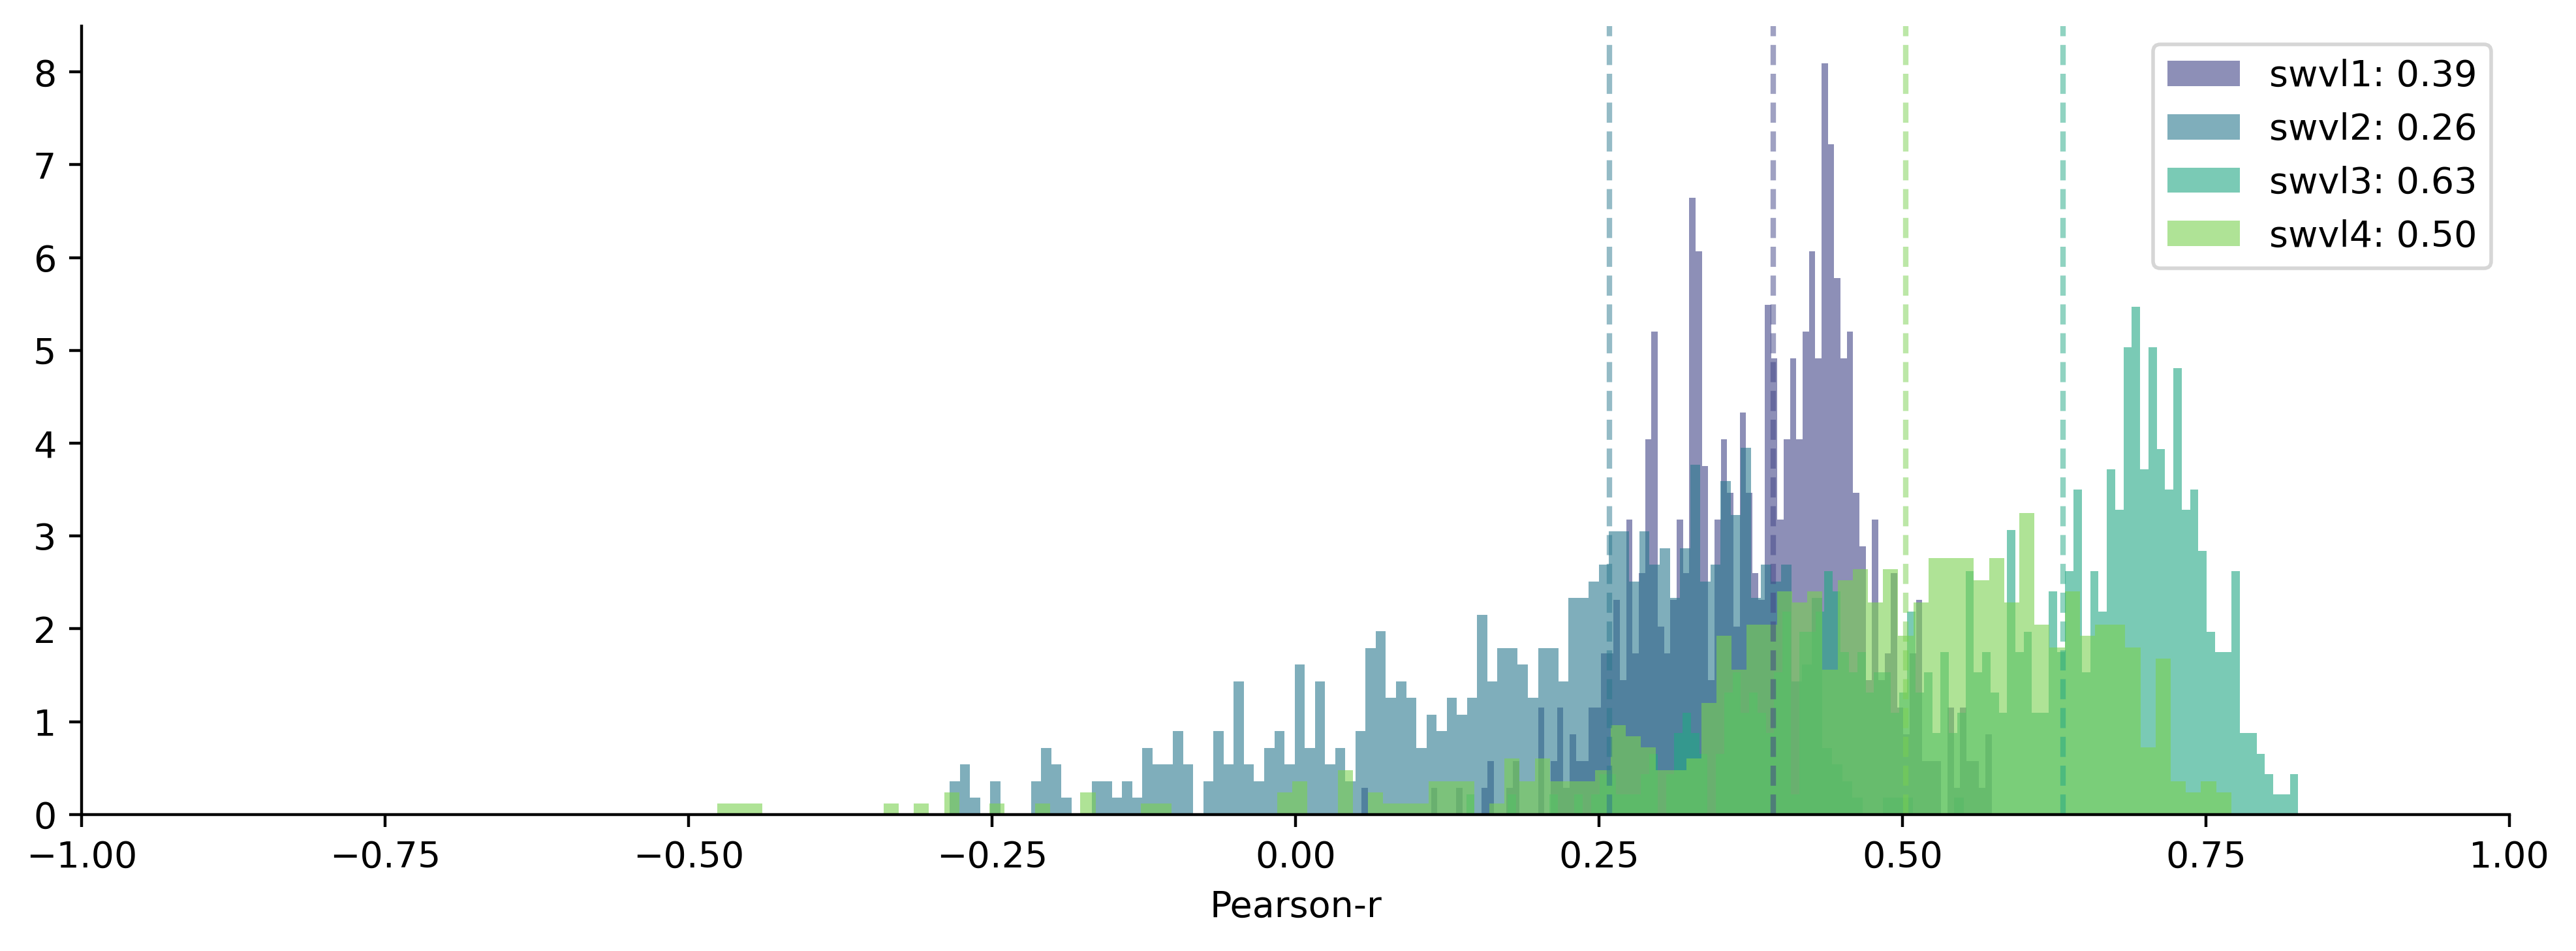

In [46]:
metric = "Pearson-r"
with plt.rc_context({"figure.dpi": 400}):
    f, ax = plt.subplots(figsize=(12, 4))

    colors = sns.color_palette("viridis", n_colors=len(target_vars))
    for ix, target_var in enumerate(shuffled_model_preds.keys()):
        errors = shifted_model_preds[target_var]["errors"]
        nse = errors[metric]

        ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"{target_var}: {nse.median().values:.2f}", alpha=0.6, color=colors[ix]);
        ax.axvline(nse.median(), color=colors[ix], ls="--", alpha=0.5)

    ax.set_xlabel(metric)
    ax.set_xlim(-1, 1)
    ax.legend()
    sns.despine()

In [41]:
from typing import DefaultDict, Dict, List
from tqdm import tqdm
from collections import defaultdict


var_ = "swvl1"
shifted_delta_dataframes = {}
for var_ in tqdm([f"swvl{i+1}" for i in range(4)], desc="Making Distance-NSE DataFrames"):
    errors = all_models_preds[var_]["errors"]
    shift_errors = shifted_model_preds[var_]["errors"]

    shifted_basin_nses = defaultdict(list)
    for sid in mapping.keys():
        try:
            nse = errors["NSE"].to_dataframe().loc[sid].values[0]
            r2 = errors["Pearson-r"].to_dataframe().loc[sid].values[0]
            remapping_sid = inv_mapping[sid]
            shifted_nse = shift_errors["NSE"].to_dataframe().loc[sid].values[0]
            shifted_r2 = shift_errors["Pearson-r"].to_dataframe().loc[sid].values[0]

            shifted_basin_nses["original_nse"].append(nse)
            shifted_basin_nses["shuffled_nse"].append(shifted_nse)
            shifted_basin_nses["original_r2"].append(r2)
            shifted_basin_nses["shuffled_r2"].append(shifted_r2)

        except KeyError:
            shifted_basin_nses["original_nse"].append(np.nan)
            shifted_basin_nses["shuffled_nse"].append(np.nan)
            shifted_basin_nses["original_r2"].append(np.nan)
            shifted_basin_nses["shuffled_r2"].append(np.nan)

            
        shifted_basin_nses["sid"].append(sid)

    shifted_basin_nses = pd.DataFrame(shifted_basin_nses).set_index("sid")
    shuffled_basin_nses["delta_nse"] = shifted_basin_nses["original_nse"] - shifted_basin_nses["shuffled_nse"]
    shifted_basin_nses["delta_r2"] = shifted_basin_nses["original_r2"] - shifted_basin_nses["shuffled_r2"]
    
    shifted_delta_dataframes[var_] = shifted_basin_nses
    
shifted_delta_dataframes[var_].head()

Making Distance-NSE DataFrames: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it]


,original_nse,shuffled_nse,original_r2,shuffled_r2,delta_r2
sid,,,,,
10002,-9.743356,-11.205024,0.852485,0.514488,0.337998
10003,0.546485,-0.061667,0.839004,0.627438,0.211566
1001,0.274699,-1.371635,0.849216,-0.000225,0.849441
101002,-10.253873,-15.500851,0.836011,0.342399,0.493613
101005,NaN,NaN,NaN,NaN,NaN


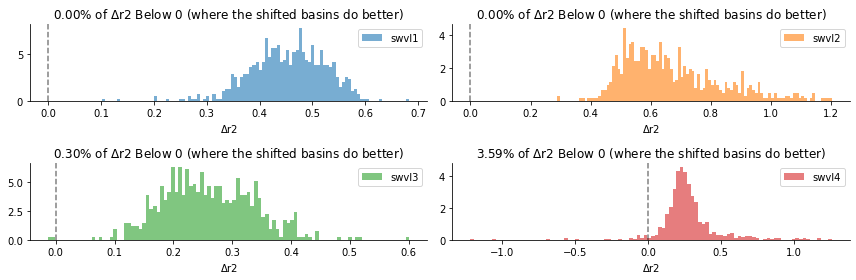

In [42]:
var_ = "swvl1"
metric = "r2"
variables = [f"swvl{i+1}" for i in range(4)]

f, axs = plt.subplots(2, 2, figsize=(12, 4))

for ix, var_ in enumerate(variables):
    ax = axs[np.unravel_index(ix, (2, 2))]
    delta_df = shifted_delta_dataframes[var_]
    ax.axvline(0, color="k", alpha=0.5, ls="--")
    ax.hist(delta_df[f'delta_{metric}'], alpha=0.6, bins=100, density=True, label=var_, color=f"C{ix}")
    prop_below_zero = float((delta_df < 0)[f'delta_{metric}'].mean())
    ax.set_title(f"{prop_below_zero * 100:.2f}% of $\Delta${metric} Below 0 (where the shifted basins do better)")
    ax.set_xlabel(f"$\Delta${metric}")
    ax.legend()
    sns.despine()
plt.tight_layout()

# Theoretical

In [43]:
assert False

AssertionError: 

In [ ]:
# create random vectors
SEED = 1
np.random.seed(SEED)

# ONLY do for one single variable
random_test_input = xr.ones_like(test_cs) * np.random.random(tuple([v for v in test_cs.dims.values()])).T
random_test_target = (xr.ones_like(test_target_ds["swvl1"]) * np.random.random(tuple([v for v in test_target_ds.dims.values()]))).to_dataset()

# display(random_test_input)
# display(random_test_target)

In [ ]:
# from scripts.cell_state.timeseries_dataset import create_train_test_datasets
# from scripts.cell_state.timeseries_dataset import TimeSeriesDataset, get_time_basin_aligned_dictionary
from scripts.cell_state.utils import create_train_test_default_dict_for_all_target_vars

# random_train_dataset, random_test_dataset = create_train_test_datasets(
#     target_var=target_var,
#     input_variables=input_variables,
#     target_ds=random_target,
#     input_ds=random_input,
#     train_start_date=train_start_date,
#     train_end_date=train_end_date,
#     test_start_date=test_start_date,
#     test_end_date=test_end_date,
#     subset_pixels=None,
#     seq_length=1,
#     basin_dim="station_id",
#     time_dim="time",
# )

# random_train = get_time_basin_aligned_dictionary(random_train_dataset)
# random_test = get_time_basin_aligned_dictionary(random_test_dataset)


if not "random_train_test" in globals().keys():
    random_train_test = create_train_test_default_dict_for_all_target_vars(
        train_cs=random_test_input,
        test_cs=random_test_input,
        train_target_ds=random_test_target,
        test_target_ds=random_test_target,
        input_variables=input_variables,
        calculate_test_set=False,
    )

In [ ]:
if not "random_model_preds" in globals().keys():
    random_model_preds = train_and_evaluate_models(random_train_test, evaluate_set="train")

In [ ]:
# random_model_preds[target_var]["errors"]
# target_var

In [ ]:
metric = "NSE"
f, ax = plt.subplots(figsize=(12, 4))

colors = sns.color_palette("viridis", n_colors=len(target_vars))
for ix, target_var in enumerate(["swvl1"]):
    errors = random_model_preds[target_var]["errors"]
    nse = errors[metric]

    ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"{target_var}: {nse.median().values:.3f}", alpha=0.6, color=colors[ix]);
    ax.axvline(nse.median(), color=colors[ix], ls="--", alpha=0.5)
    
ax.set_xlabel(metric)
ax.set_xlim(-1, 1)
ax.legend()
sns.despine()

In [ ]:
random_preds = random_model_preds["swvl1"]["preds"]
random_errors = random_model_preds["swvl1"]["errors"]
random_model = random_model_preds["swvl1"]["model"]

In [ ]:
nse = errors["NSE"]
random_nse = random_errors["NSE"]

f, ax = plt.subplots(figsize=(12, 4))
ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"Test Data {nse.median().values:.3f}", alpha=0.6);
ax.axvline(nse.median(), color="C0", ls="--", alpha=0.5)

ax.hist(random_nse.where(random_nse > -1, -1), bins=10, density=True, label=f"random Data {random_nse.median().values:.3f}", alpha=0.6, color="C2");
ax.axvline(random_nse.median(), color="C2", ls="--", alpha=0.5)

ax.set_xlim(-1, 1)
ax.set_ylim(0, 3)
ax.legend()

nse_diff = np.abs(float(random_nse.median()) - float(nse.median()))
ax.set_title(f"Randomly generating features (Median NSE improved by {nse_diff:.2f})")
sns.despine()

In [ ]:

px = np.random.choice(preds.station_id.values)
time = "2007"

random = random_preds.sel(station_id=px, time=time)
data = preds.sel(station_id=px, time=time)

f, ax = plt.subplots(figsize=(12, 4))
# ax.plot(data.time, random.obs)
ax.plot(data.time, data.obs, color="k", ls="--", alpha=0.3)
ax.plot(data.time, data.sim, color="C0", ls="-", alpha=0.6, label="Original Data")
ax.plot(data.time, random.sim, color="C2", ls="-", alpha=0.6, label="random Data")
ax.legend()
sns.despine()

In [ ]:
from scripts.cell_state.analysis import get_model_weights, plot_weights

w, b = get_model_weights(model)
r_w, r_b = get_model_weights(random_model)

ext = np.concatenate([w, b])
r_ext = np.concatenate([r_w, r_b])

# f, axs = plt.subplots(2, 1, figsize=(12, 2*2))
plot_weights(np.abs(ext), kwargs={"vmin": 0.0, "vmax": 0.3}, ax=None)
ax = plot_weights(np.abs(r_ext), kwargs={"vmin": 0.0, "vmax": 0.3}, ax=None)